In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from EDA_functions import categorical_associations,plot_feature_relationships, plot_distributions
from na_matrix import plot_missing_data_matrix
import missingno as mmsno
from scipy.stats import chi2_contingency
import scipy.stats as stats
from data_splitter import split_and_save_data
from transform_data import transform_data

ModuleNotFoundError: No module named 'EDA_functions'

In [2]:
# loading the merged csv dataset:
data_22 = pd.read_csv('datasets/italy_2022.csv')
print(data_22.shape)

(10552, 47)


In [4]:
data_22.columns

Index(['CNTSCHID', 'CNTSTUID', 'ST004D01T', 'PROGN', 'IMMIG', 'LANGN',
       'REPEAT', 'BELONG', 'BULLIED', 'PERSEVAGR', 'COOPAGR', 'STRESAGR',
       'EMOCOAGR', 'FAMSUP', 'ANXMAT', 'SCHSUST', 'LEARRES', 'PROBSELF',
       'FAMSUPSL', 'FEELLAH', 'HISCED', 'ICTRES', 'ESCS', 'PV1MATH',
       'SC001Q01TA', 'SC011Q01TA', 'SC037Q02TA', 'SC187Q04WA', 'SC180Q01JA',
       'SC218Q01JA', 'SCHLTYPE', 'SCHSIZE', 'PROATCE', 'PROPSUPP', 'SCHAUTO',
       'TCHPART', 'INSTLEAD', 'RATCMP1', 'STAFFSHORT', 'EDUSHORT', 'STUBEHA',
       'TEACHBEHA', 'CLSIZE', 'SCSUPRTED', 'PROBSCRI', 'SCPREPAP', 'DIGPREP'],
      dtype='object')

In [5]:
# a new df with some basic data cleaning is returned
df = transform_data(data_22)

In [6]:
df.isnull().mean()* 100

schoolID                     0.000000
studentID                    0.000000
Gender                       0.000000
PROGN                        0.000000
IMMIG                        0.000000
LANGN                        0.714993
REPEAT                       0.802992
BELONG                       1.264987
BULLIED                      1.132989
PERSEVAGR                    2.463975
COOPAGR                      2.727973
STRESAGR                     3.794962
EMOCOAGR                     4.025960
FAMSUP                      10.086899
ANXMAT                       6.764932
ESCS                         0.857991
PV1MATH                      0.000000
municipality_size            4.113959
degree_of_competition        4.971950
external_evaluation          7.787922
math_grouping                6.511935
additional_math_classes      5.796942
track_student_attendance    13.848862
SCHLTYPE                     0.527995
SCHSIZE                      5.609944
PROATCE                      9.921901
PROPSUPP    

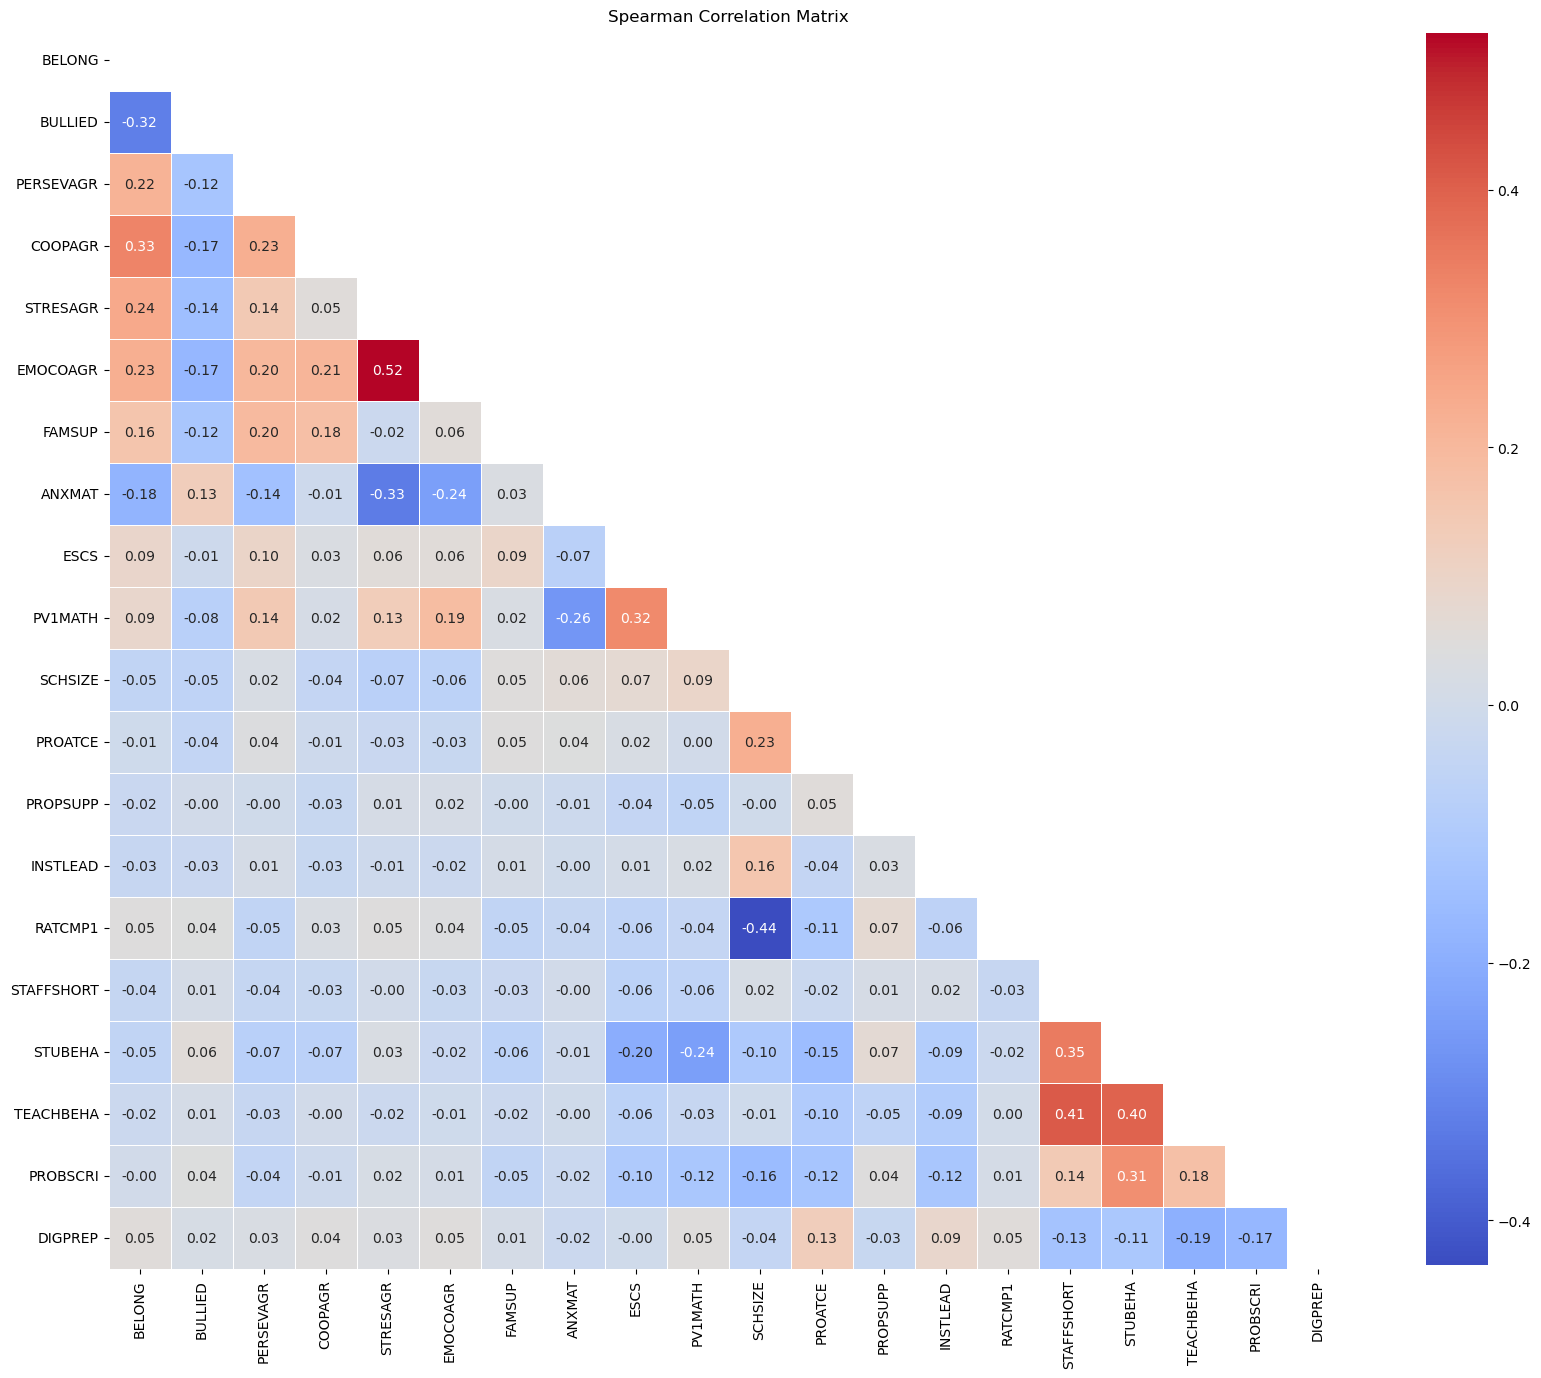

In [7]:
continuos_cols = [col for col in df.columns if col not in df.select_dtypes(include=['category', 'object']).columns and col not in ['schoolID', 'studentID']] + ['SCHAUTO_ORDINAL', 'EDUSHORT_binned']
categorical_cols = [col for col in df.columns if col not in continuos_cols and col not in ['schoolID', 'studentID']]
corr = df[continuos_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Spearman Correlation Matrix')
plt.show()

In [10]:
associations = categorical_associations(df, categorical_cols)
associations.to_csv('categorical_variables_chi2_results.csv', index = False)

The chi squared test showed signifcant association for the following features:
    - Gender and PROGN (P-Value: ~4.42e-98, extremely significant).
    - Gender and degree_of_competition (P-Value: ~8.88e-07).
    - PROGN and CLSIZE (P-Value: ~6.88e-108).
    - IMMIG and LANGN (P-Value: ~5.42e-178, extremely significant).

I suspect the first refers to the fact that females tend to attend academic tracks more than males. The second might be a byproduct of the first: if we assume academic tracks have higher degree of competition levels (maybe because they are located in city centers, in which generally speaking there are more schools), and given that females tend to attend academic tracks, then Gender and degree_of_competition will be associated. The third is probably due to the fact that there is a disbalance in the samples size for each PROGN, so I wouldn't consider it meaningful. Finally, the fourth actually finds a trivial association.

In [16]:
for prog in df.PROGN.unique():
    subset = df[df['PROGN'] == prog]
    contingency_table = pd.crosstab(subset['Gender'], subset['degree_of_competition'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"PROGN: {prog}")
    print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")
    print()

PROGN: Vocational
Chi-Square Statistic: 5.52318927960344, P-Value: 0.0631909212154983

PROGN: Academic
Chi-Square Statistic: 0.38886907063629805, P-Value: 0.8233000735697682

PROGN: Technical
Chi-Square Statistic: 34.45000945385957, P-Value: 3.305791786821059e-08



In [8]:
df.to_csv('dataset_before_splitting.csv', index = False)

In [9]:
results = split_and_save_data(df, 'PV1MATH', 'schoolID')

In [11]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')

In [23]:
print(X_train.shape, X_test.shape)

(7248, 28) (1843, 28)


In [19]:
y_train.describe().round(2)

,PV1MATH
count,7248.00
mean,484.89
std,86.48
min,196.33
25%,425.06
50%,484.08
75%,546.40
max,767.84


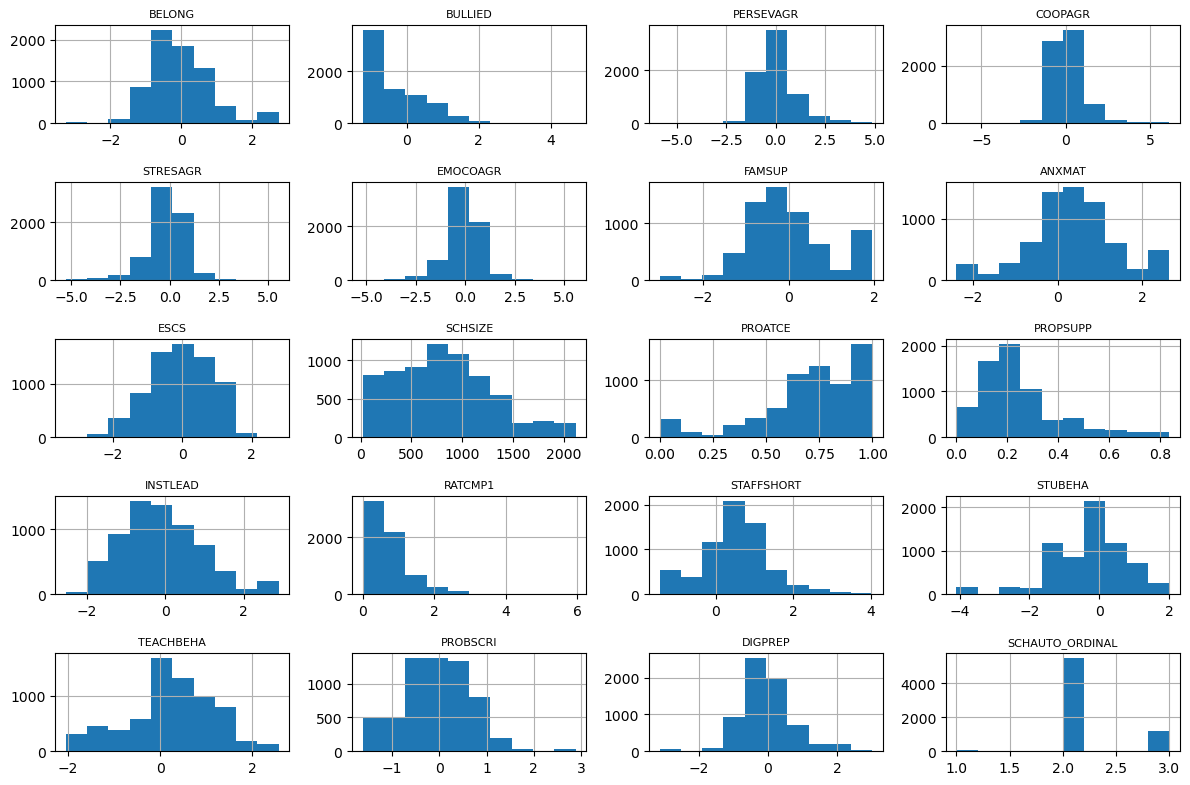

In [13]:
continuos_cols = [col for col in X_train if col not in X_train.select_dtypes(include=['category', 'object']).columns]
subset = X_train[continuos_cols]

axes = subset.hist(figsize=(12, 8), bins=10)
plt.tight_layout()
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=8)
plt.show()

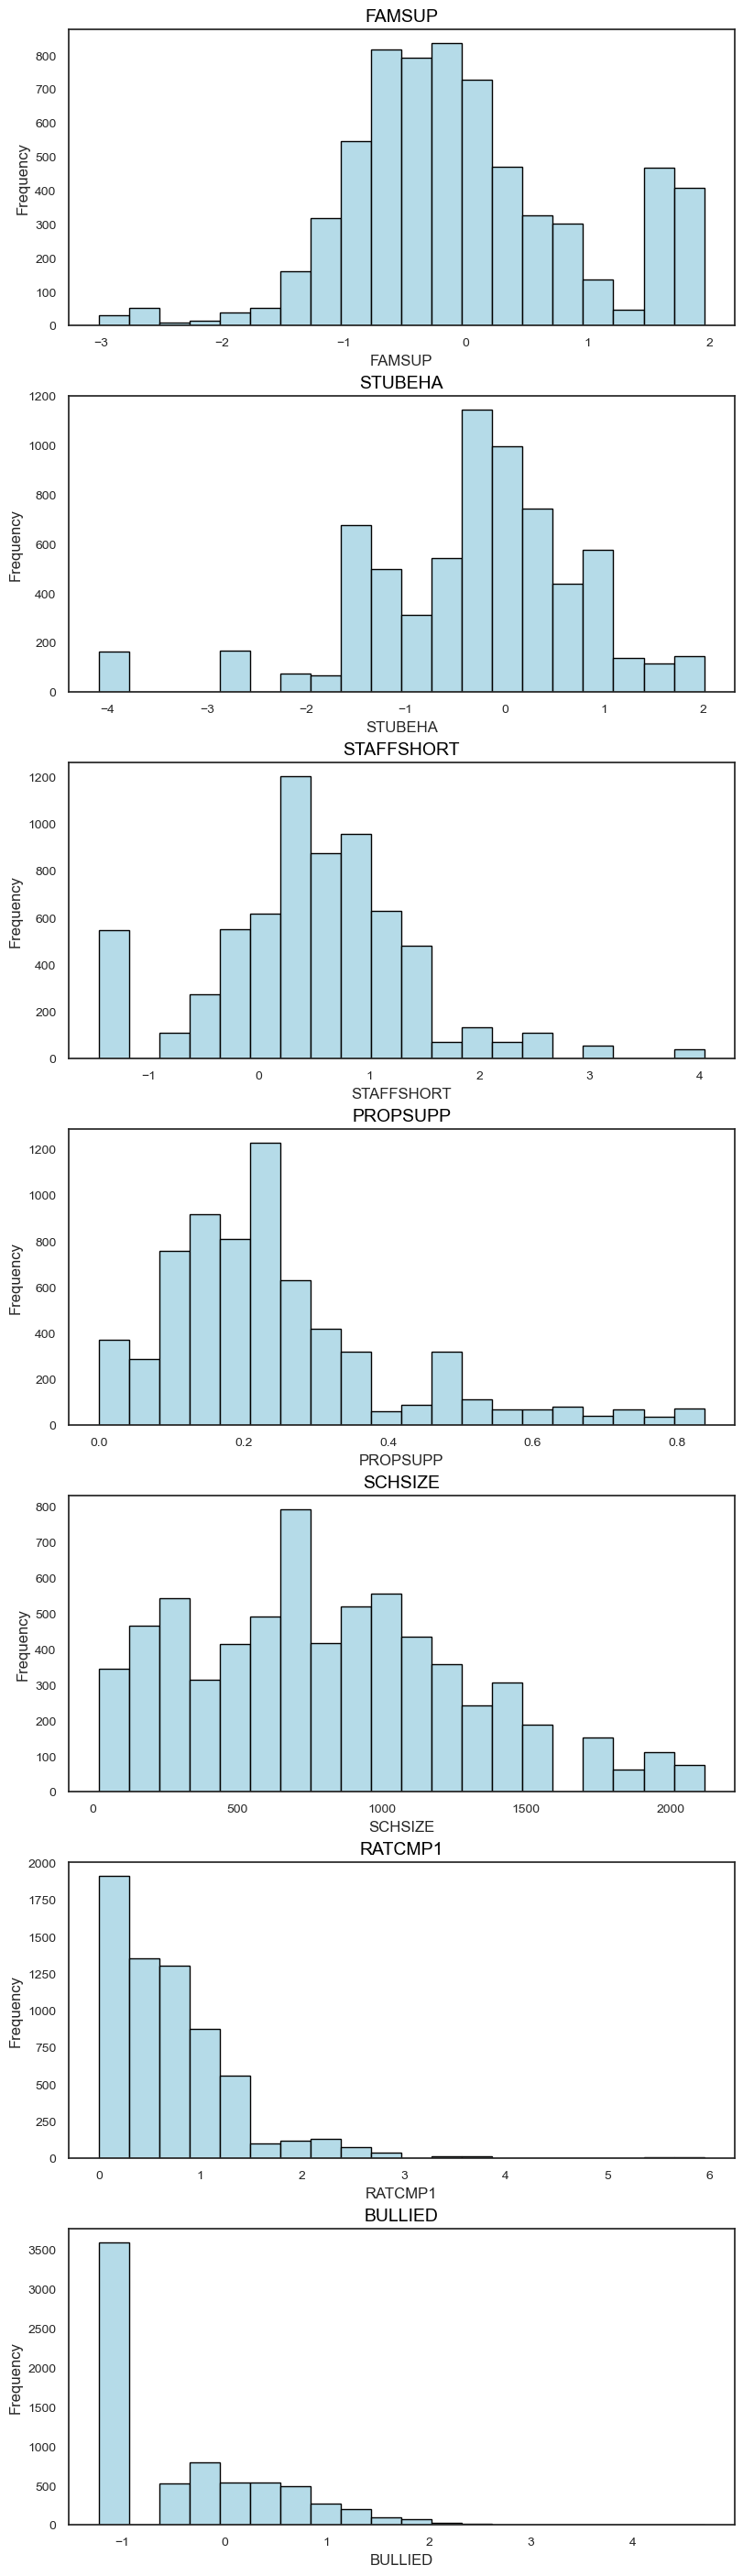

In [26]:
# highly skewed data before 
plot_distributions(X_train, ['FAMSUP', 'STUBEHA', 'STAFFSHORT', 'PROPSUPP', 'SCHSIZE', 'RATCMP1', 'BULLIED'])

In [18]:
# distinguish between student and school predictors for later analysis:
st_cols = ['Gender', 'PROGN', 'IMMIG', 'LANGN', 'REPEAT', 'FAMSUP', 'ESCS', 'PROBSCRI', 'BELONG', 'BULLIED', 'PERSEVAGR', 'COOPAGR', 'STRESAGR', 'EMOCOAGR', 'ANXMAT']
sch_cols = [x for x in X_train.columns if x not in st_cols]

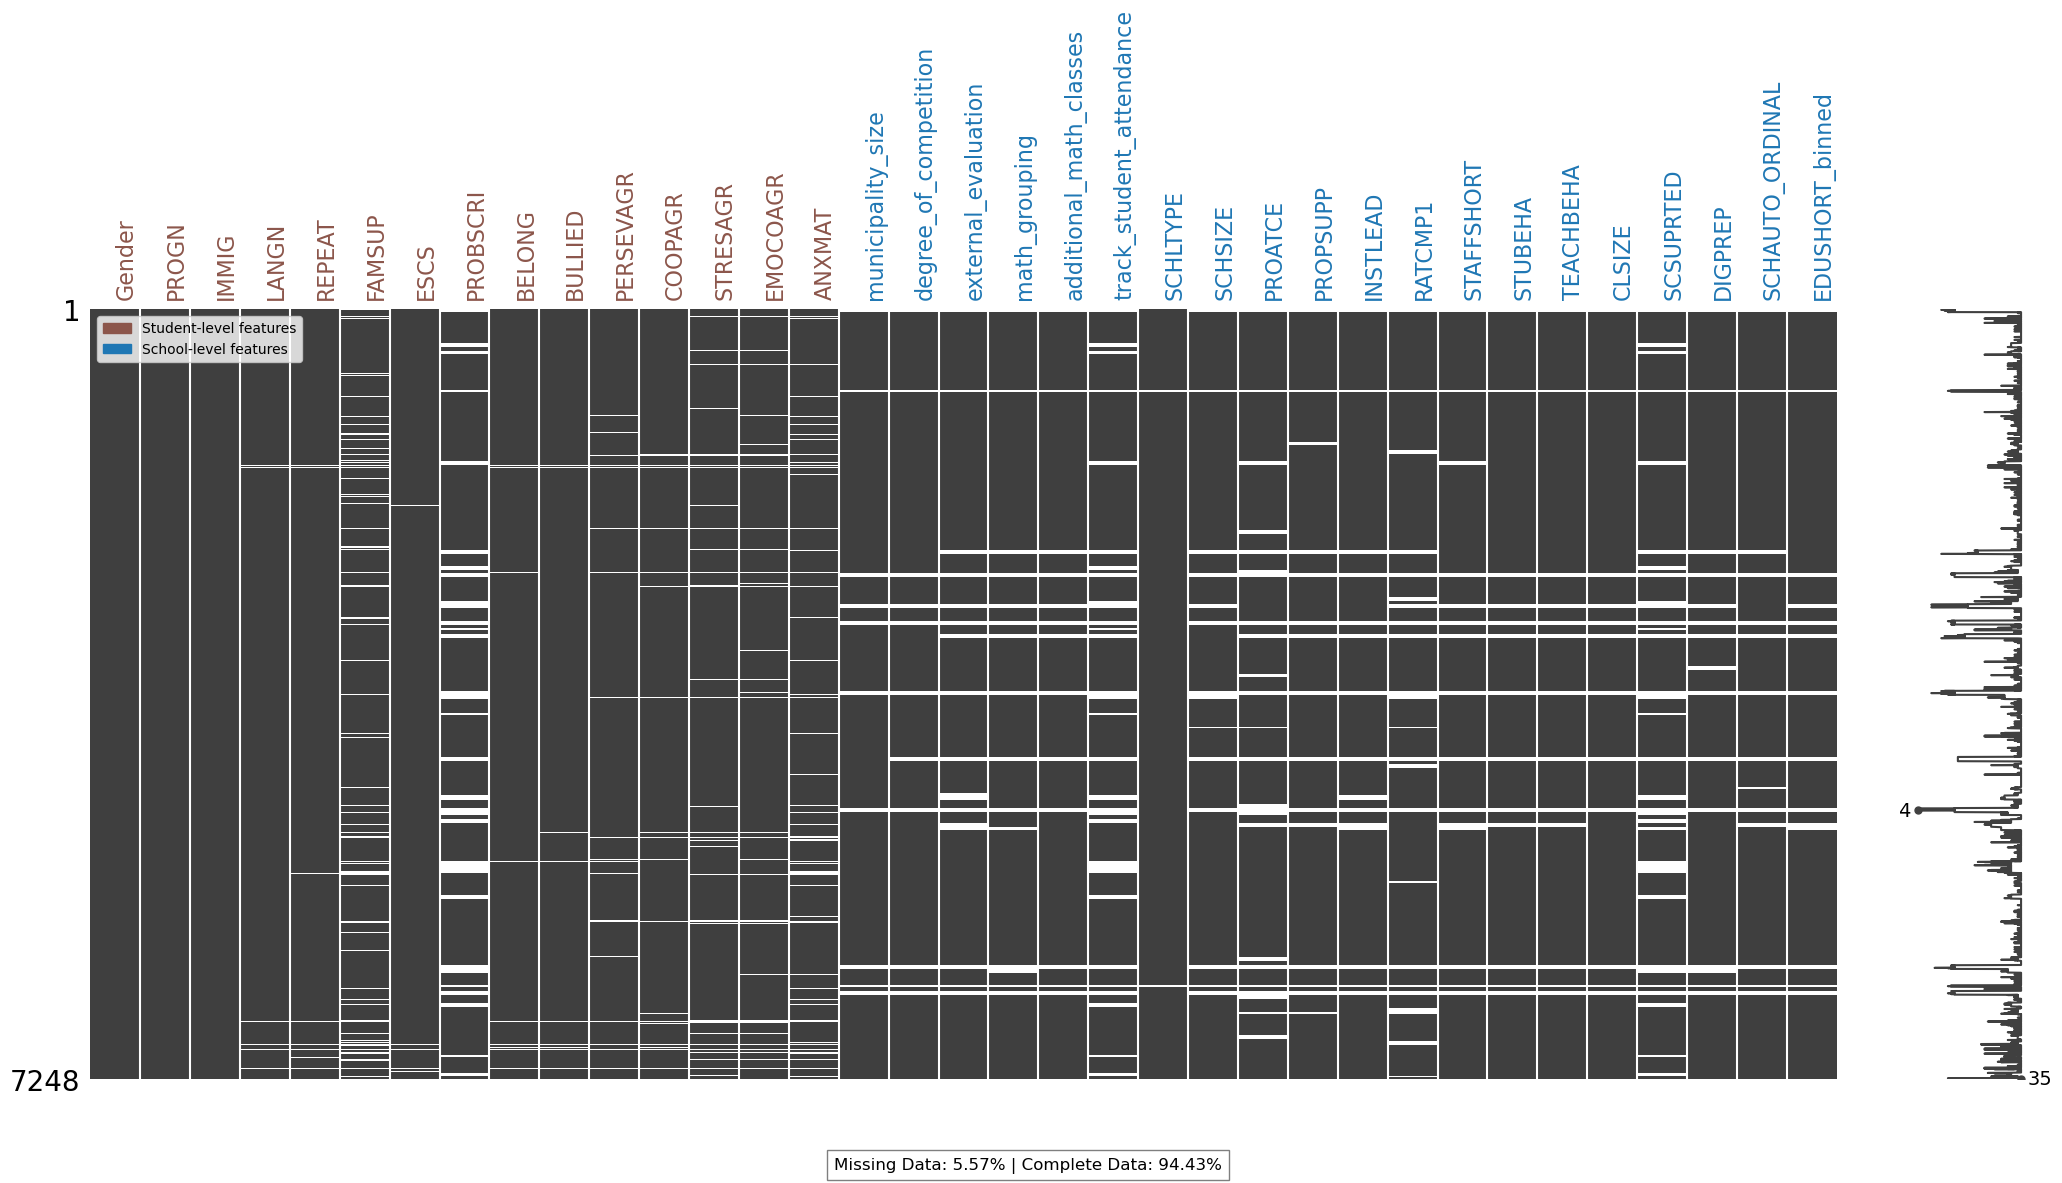

In [19]:
plot_missing_data_matrix(X_train, st_cols, sch_cols)

In [20]:
# let's see how missingness relate to some 'demographic' variables:
def heatmap_missing_by_group(df, column):
    missing_by_group = df.groupby(column).apply(lambda x: x.isna().mean()).T
    plt.figure(figsize=(12, 10))
    sns.heatmap(missing_by_group, annot=True, cmap="YlGnBu", cbar=True)
    plt.title(f"Proportion of Missing Responses by {column}")
    plt.show()

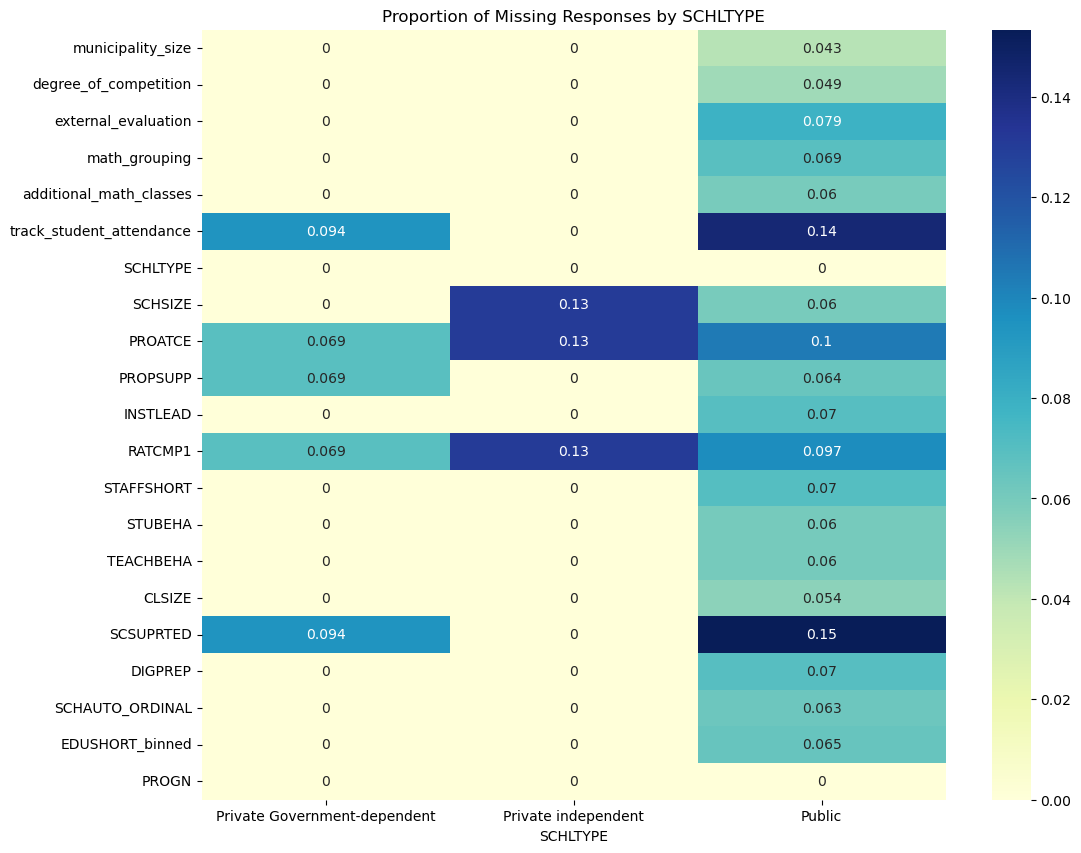

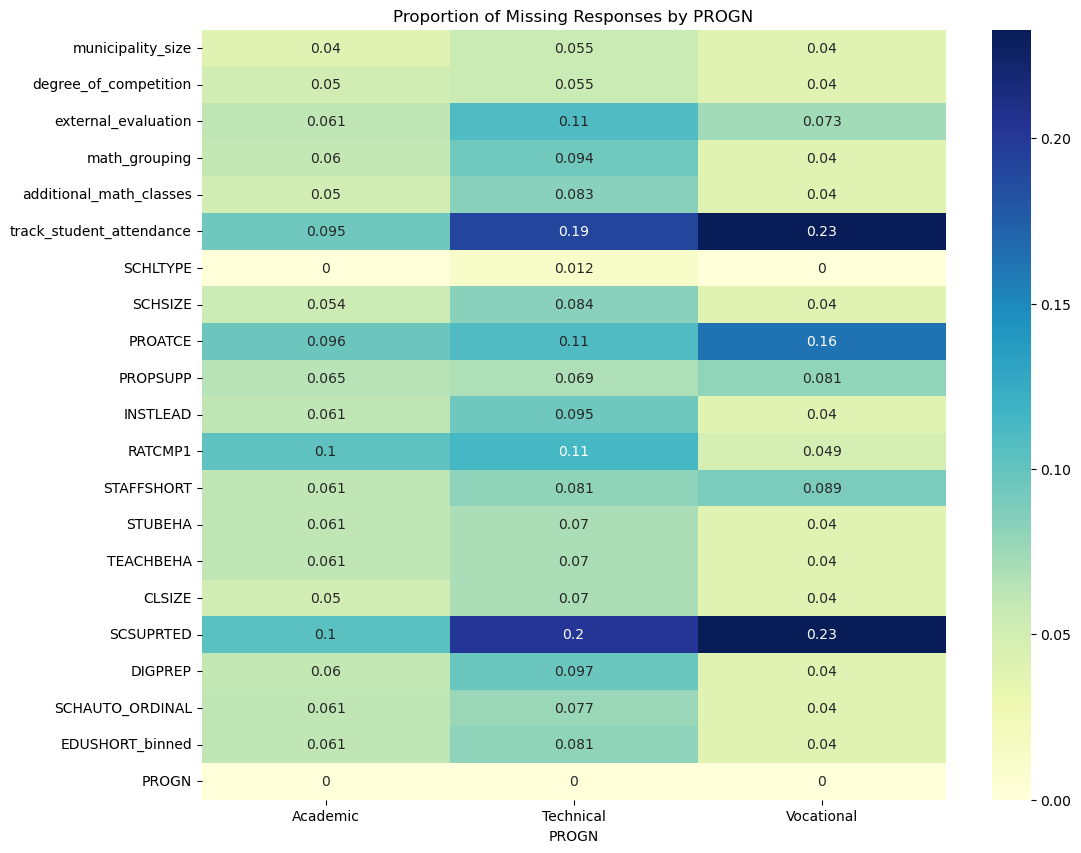

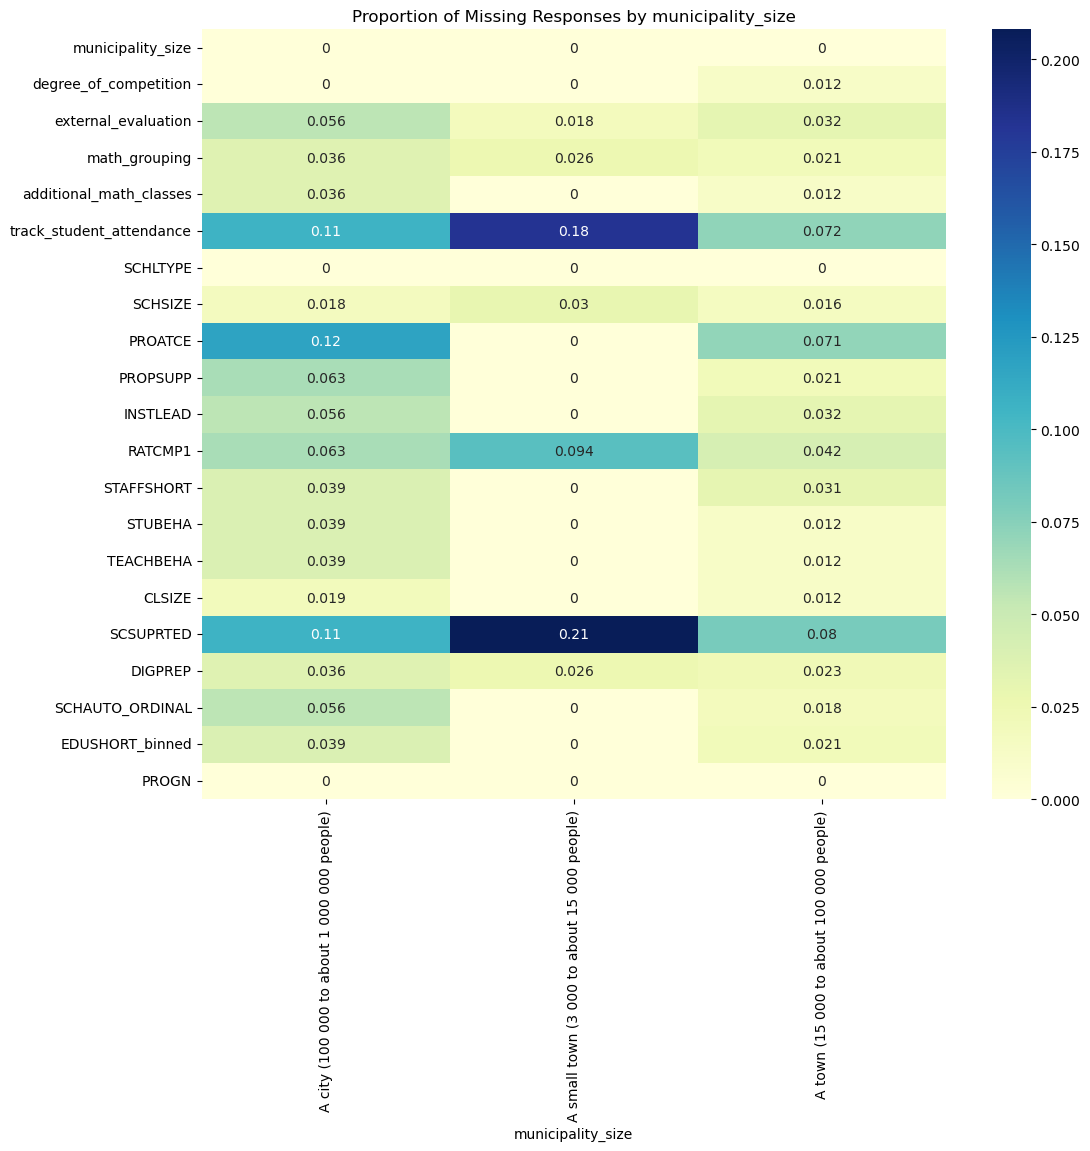

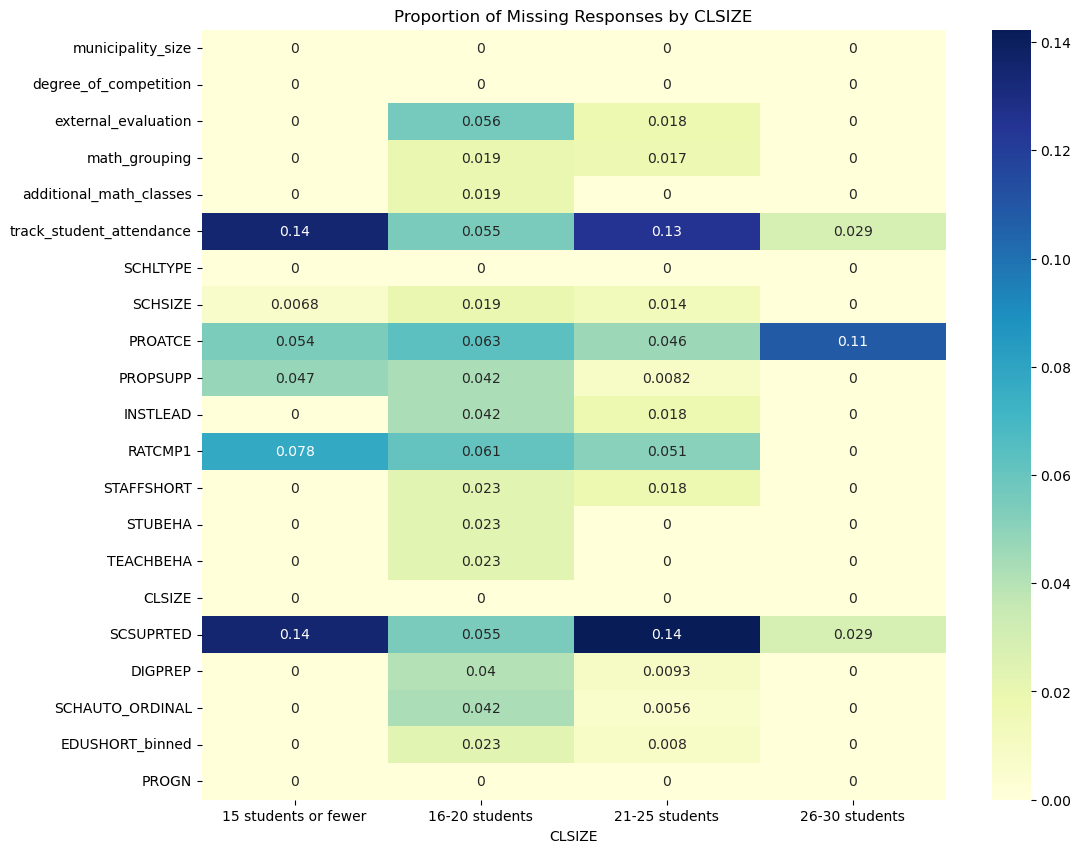

In [21]:
df = X_train[sch_cols].join(X_train[['PROGN']], how='left') # adding PROGN column to the other school columns
groups = ['SCHLTYPE', 'PROGN', 'municipality_size', 'CLSIZE'] 
for group in groups:
    heatmap_missing_by_group(df, group)

In [ ]:
# smaller classes seems to appear in smaller schools, therefore the above plot of CLSIZE can be interpreted as larger schools
X_train.groupby('CLSIZE')['SCHSIZE'].agg(['min', 'max', 'mean']).reset_index()

,CLSIZE,min,max,mean
0,15 students or fewer,73.0,734.0,306.955782
1,16-20 students,69.0,1384.0,609.661364
2,21-25 students,21.0,2000.0,832.887453
3,26-30 students,106.0,2116.0,1275.257900


The plot examines missing data patterns across four grouping variables: SCHLTYPE (school type), PROGN (educational track), municipality_size, and CLSIZE (class size). Key insights include:

    - Consistent High Missingness: Variables like PROBSUPP (Problems with Support), SCHSUPT (School Support Services), FAMSUPPL (Family Support), SCSUPRTED (School Community Support), and DIGPREP (Digital Preparation) show high and consistent missingness across all groups.

     - Group-Specific Patterns:
        Private Schools and Vocational Programs exhibit higher missing rates in support and attendance tracking questions.
        Smaller Class Sizes have more missing data on support services and digital resources, likely reflecting resource limitations.

    - Minimal Variation by Municipality Size: Missingness patterns do not vary significantly by municipality_size, indicating that municipality size does not strongly impact data availability.

Overall, these findings suggest that missingness is more associated with school type, program orientation, and class size than with municipality size, and that specific variables consistently show high missingness, likely due to relevance or reporting challenges.

<AxesSubplot:>

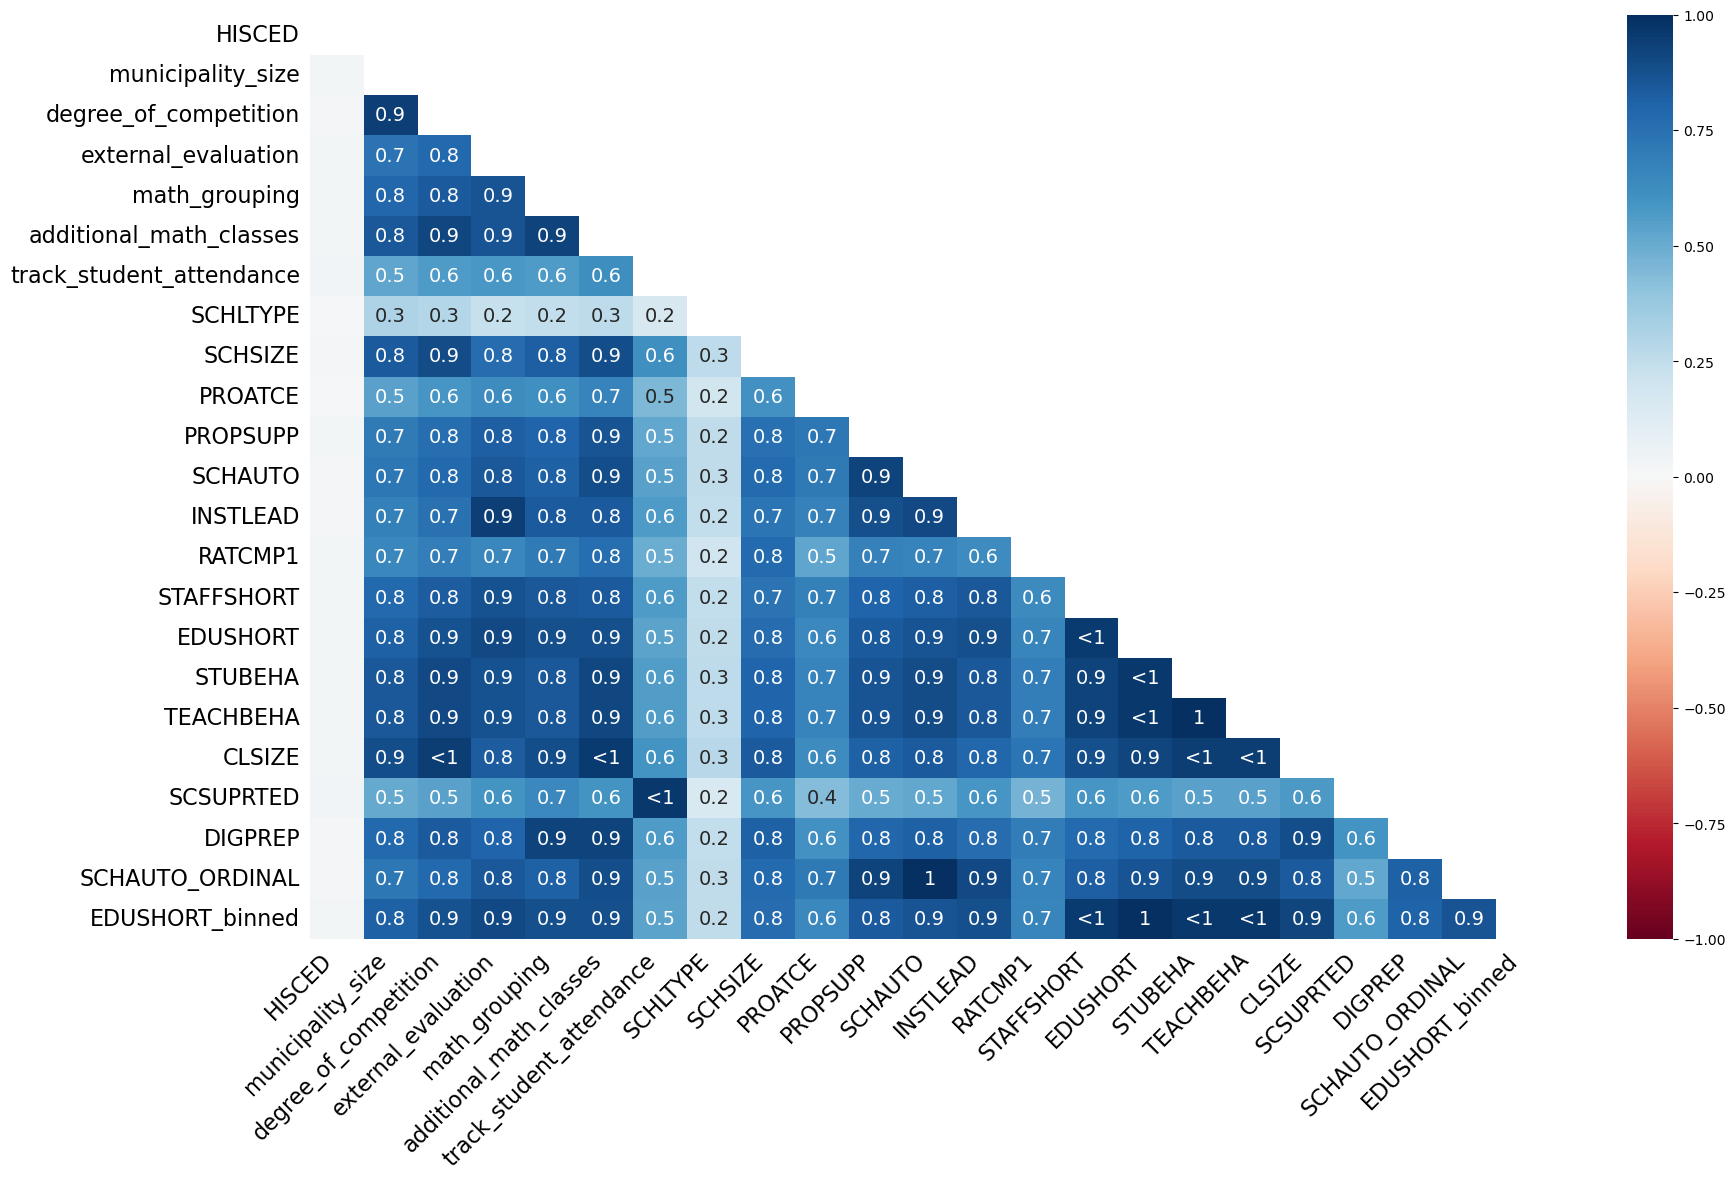

In [69]:
# missing data heatmap for school features. The high dependency of missing values is confirmed:
mmsno.heatmap(X_train[sch_cols])

<AxesSubplot:>

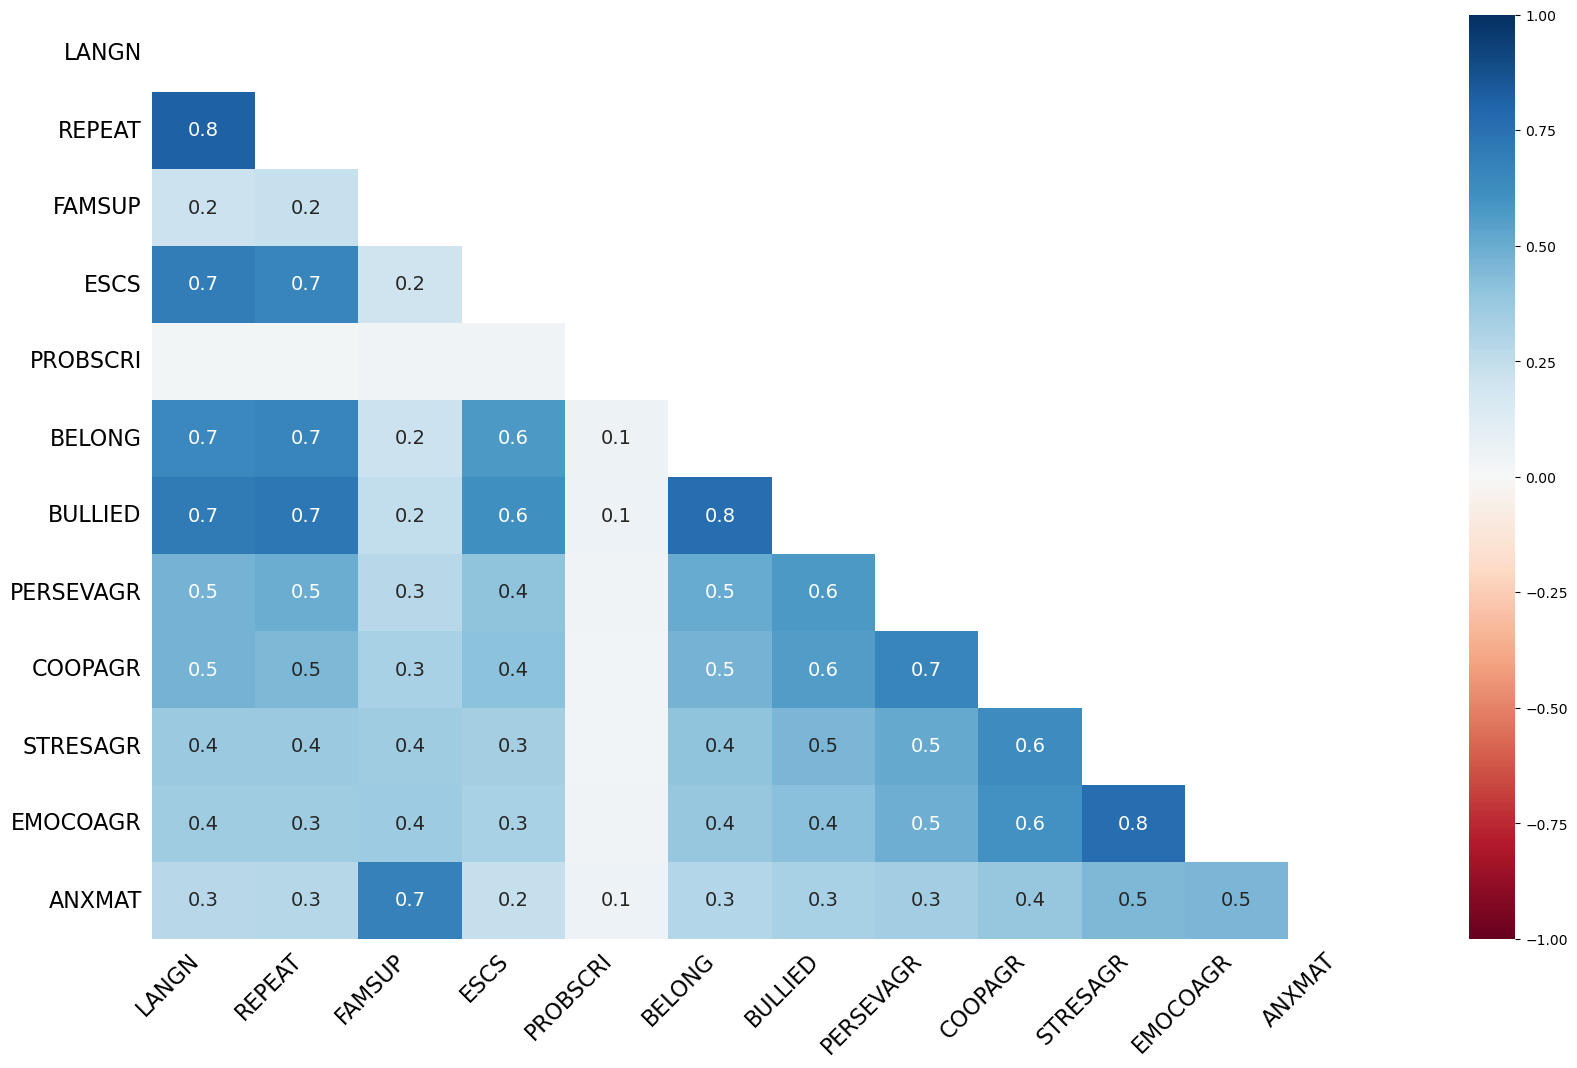

In [22]:
# missing data heatmap for student features. The dependency is much less evident here:
mmsno.heatmap(X_train[st_cols])

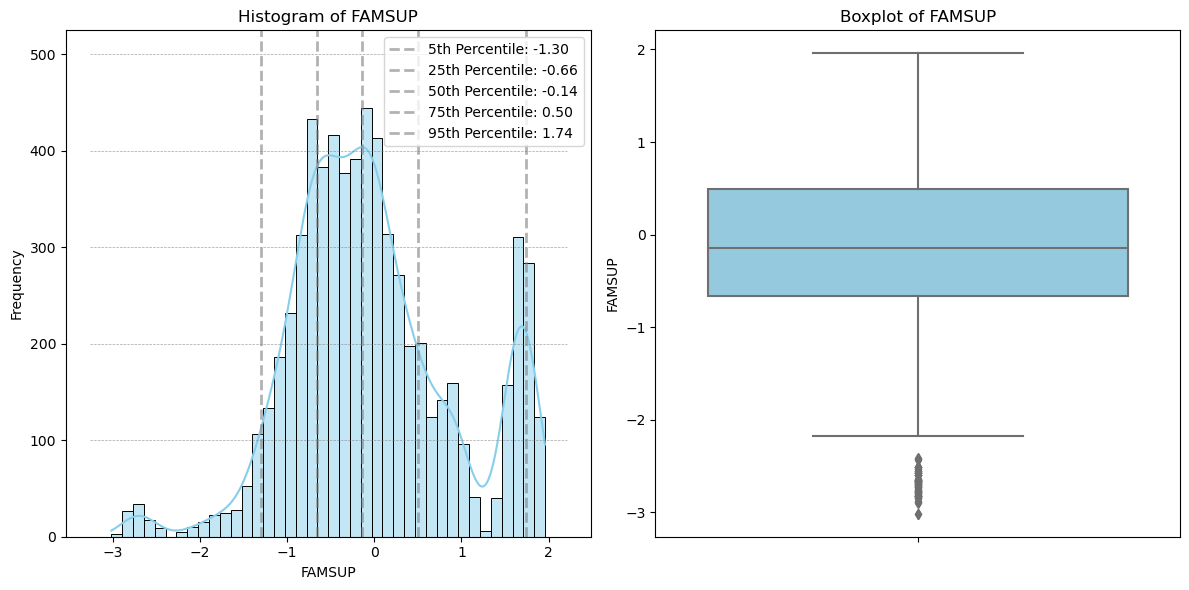

In [26]:
plot_histogram_boxplot(X_train, 'FAMSUP')

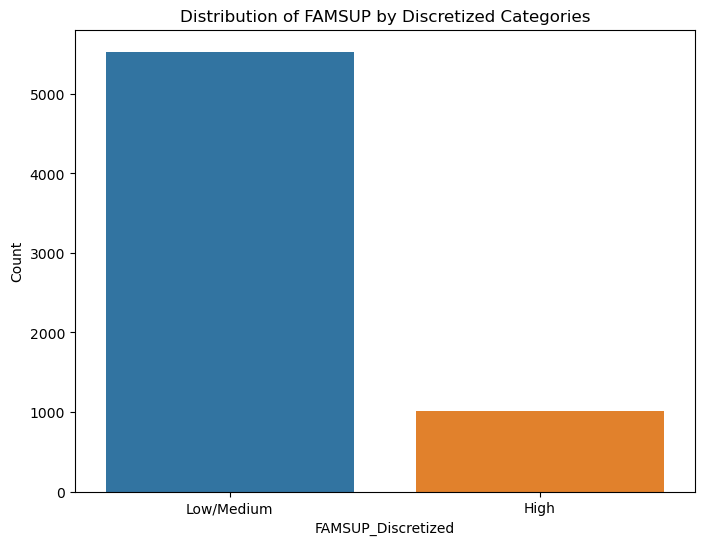

In [19]:
# discretization by two categories
X_train['FAMSUP_Discretized'] = pd.cut(X_train['FAMSUP'], bins=[-np.inf, 1, np.inf], labels=['Low/Medium', 'High'])
category_counts = X_train['FAMSUP_Discretized'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Distribution of FAMSUP by Discretized Categories")
plt.xlabel("FAMSUP_Discretized")
plt.ylabel("Count")
plt.show()

In [22]:
# correlation with ESCS doesn't seem to be informative. Let's try with HISCED (highest educational level of parents)
hisced = X_train.dropna(subset=['HISCED']).copy()
# Combine low categories
hisced['HISCED'] = hisced['HISCED'].replace({
    'ISCED level 1': 'Low Education',
    'Less than ISCED Level 1': 'Low Education'
})

contingency_table = pd.crosstab(hisced['FAMSUP_Discretized'], hisced['HISCED'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Squared Test: chi2 = {chi2}, p-value = {p}")

Chi-Squared Test: chi2 = 9.913184248371962, p-value = 0.27117222151630277


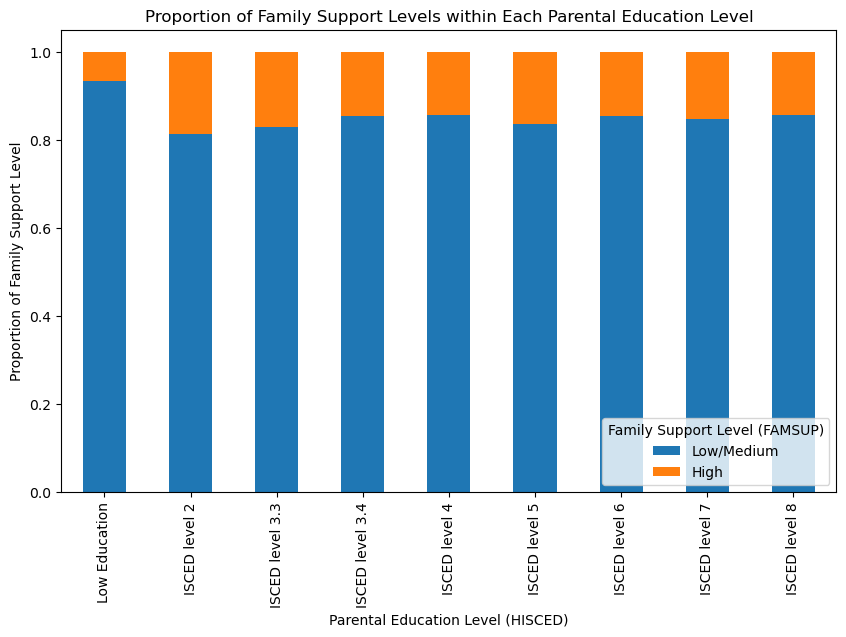

In [21]:
hisced_order = [
    "Low Education", "ISCED level 2", "ISCED level 3.3", "ISCED level 3.4",
    "ISCED level 4", "ISCED level 5", "ISCED level 6", "ISCED level 7", "ISCED level 8"
]
contingency_table_prop = contingency_table.div(contingency_table.sum(axis=0), axis=1)
contingency_table_prop = contingency_table_prop.reindex(columns=hisced_order)
contingency_table_prop.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Proportion of Family Support Levels within Each Parental Education Level")
plt.xlabel("Parental Education Level (HISCED)")
plt.ylabel("Proportion of Family Support Level")
plt.legend(title="Family Support Level (FAMSUP)", loc="lower right", bbox_to_anchor=(1, 0))
plt.show()

From the graph above only students coming from the less educated families have significant higher proportion of low support level. For the other groups the proportion of low support level is almost the same. This confirms the results of the test: there is no significant association between parents level of education and support for schooling activities.

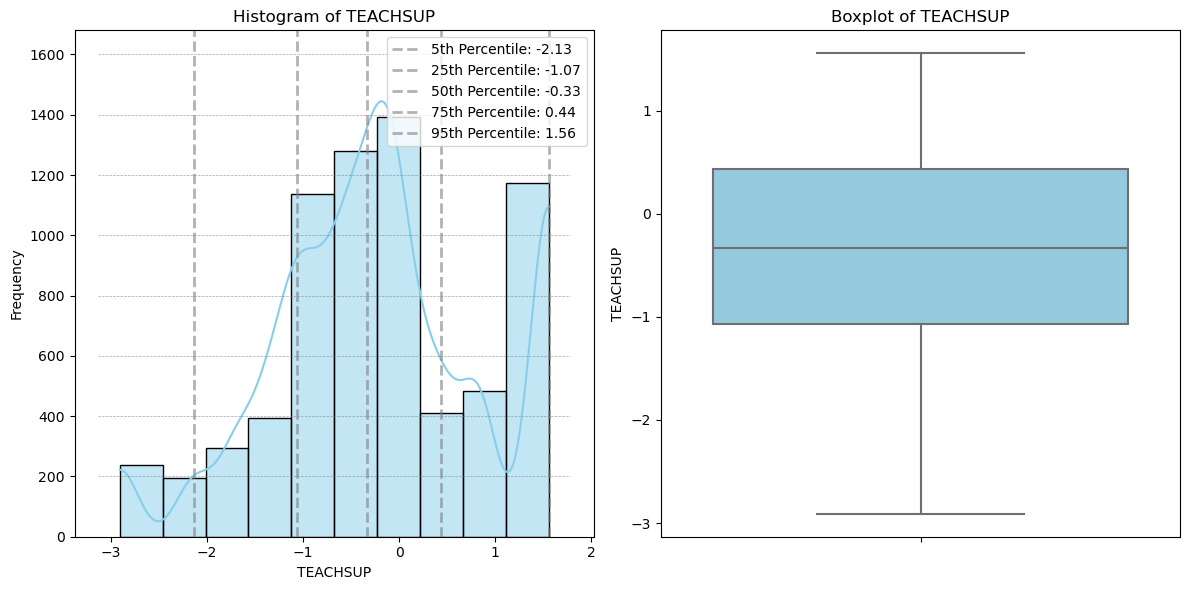

In [27]:
plot_histogram_boxplot(X_train, 'TEACHSUP', bins= 10)

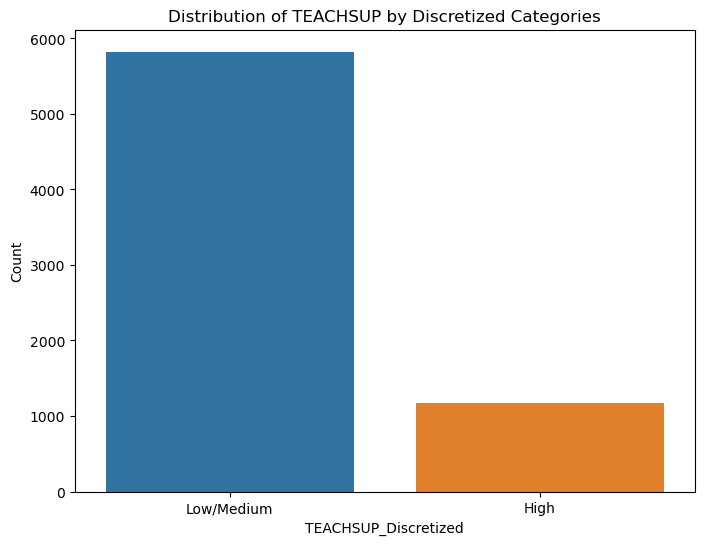

In [50]:
# also here teacher support exibits a bimodal distribution. Let's see if it is correlated with educational track:
# discretization by two categories
X_train['TEACHSUP_Discretized'] = pd.cut(X_train['TEACHSUP'], bins=[-np.inf, 1, np.inf], labels=['Low/Medium', 'High'])
category_counts = X_train['TEACHSUP_Discretized'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Distribution of TEACHSUP by Discretized Categories")
plt.xlabel("TEACHSUP_Discretized")
plt.ylabel("Count")
plt.show()


In [51]:
contingency_table = pd.crosstab(X_train['PROGN'], X_train['TEACHSUP_Discretized'])
# chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)

Chi-square Statistic: 29.646483998444182
P-value: 3.650461696315689e-07
Degrees of Freedom: 2
Expected Frequencies Table:
[[3121.33771616  628.66228384]
 [2117.51550665  426.48449335]
 [ 585.14677719  117.85322281]]


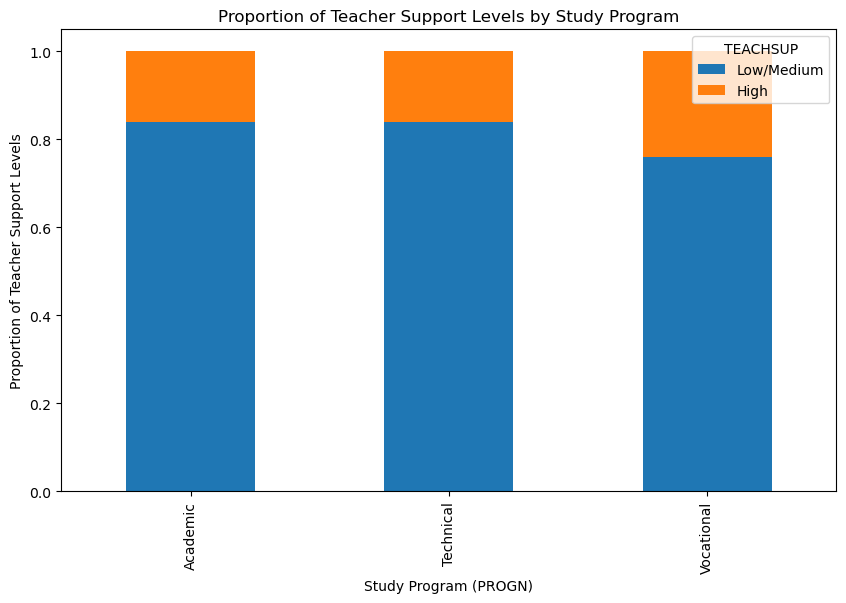

In [52]:
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Study Program (PROGN)')
plt.ylabel('Proportion of Teacher Support Levels')
plt.title('Proportion of Teacher Support Levels by Study Program')
plt.legend(title='TEACHSUP')
plt.show()

In [16]:
mean_support_by_program = X_train.groupby('PROGN')['TEACHSUP'].agg(['mean', 'min', 'max', 'std'])
mean_support_by_program.columns = ['Mean Teacher Support Level', 'Min Teacher Support Level', 'Max Teacher Support Level', 'Std Dev of Teacher Support Level']
mean_support_by_program

,Mean Teacher Support Level,Min Teacher Support Level,Max Teacher Support Level,Std Dev of Teacher Support Level
PROGN,,,,
Academic,-0.229021,-2.9095,1.5558,1.118820
Technical,-0.228134,-2.9095,1.5558,1.115145
Vocational,0.015576,-2.9095,1.5558,1.128159


Levels of teacher support are higher in vocational schools: this is likely due to the fact that weaker students concentrate in these institutes.

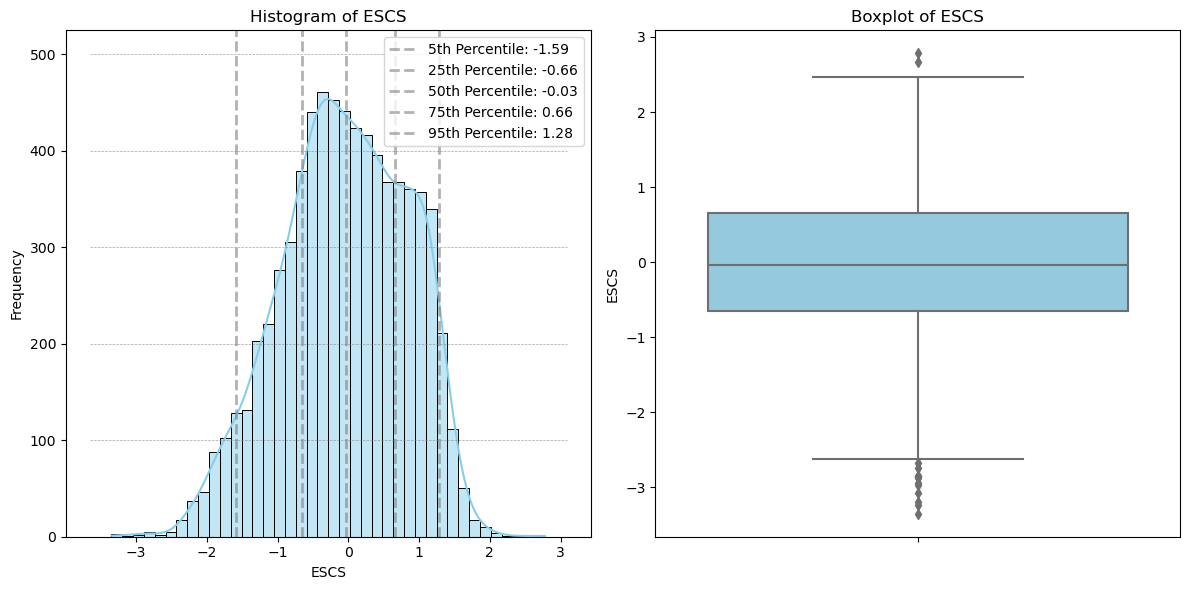

In [28]:
plot_histogram_boxplot(X_train, 'ESCS')

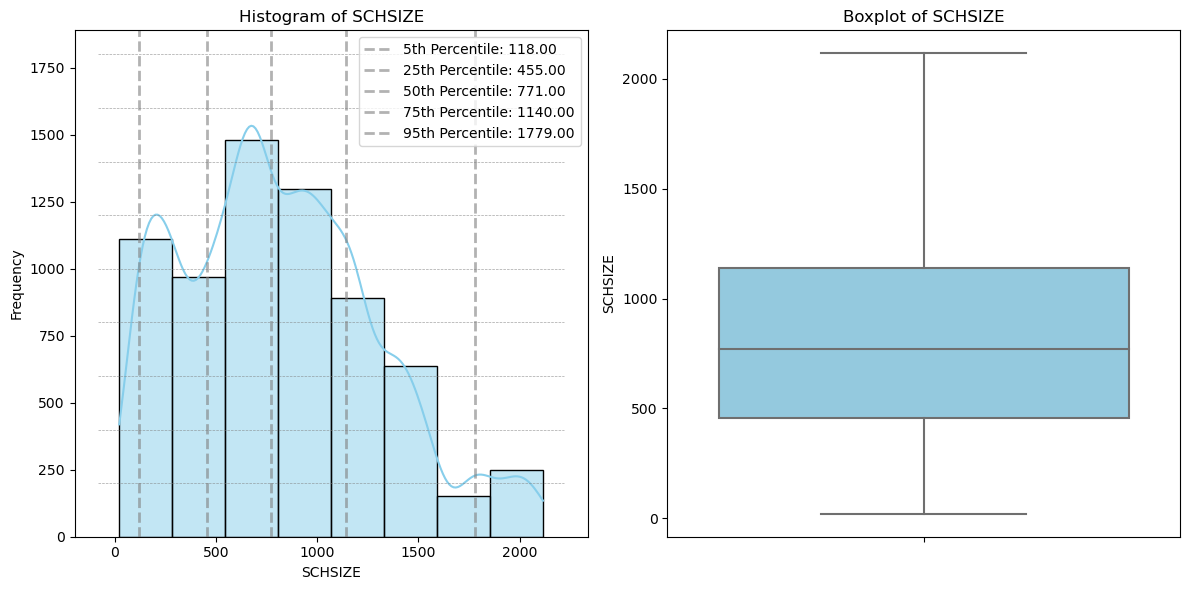

In [29]:
plot_histogram_boxplot(X_train, 'SCHSIZE', bins = 8)

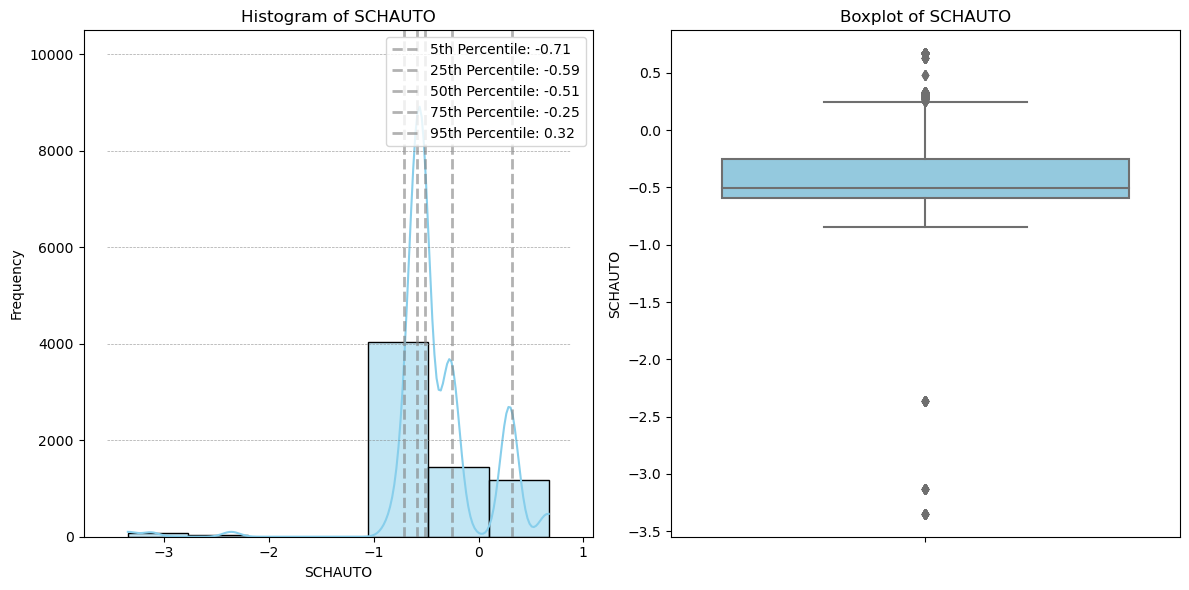

In [30]:
plot_histogram_boxplot(X_train, 'SCHAUTO', bins = 7)

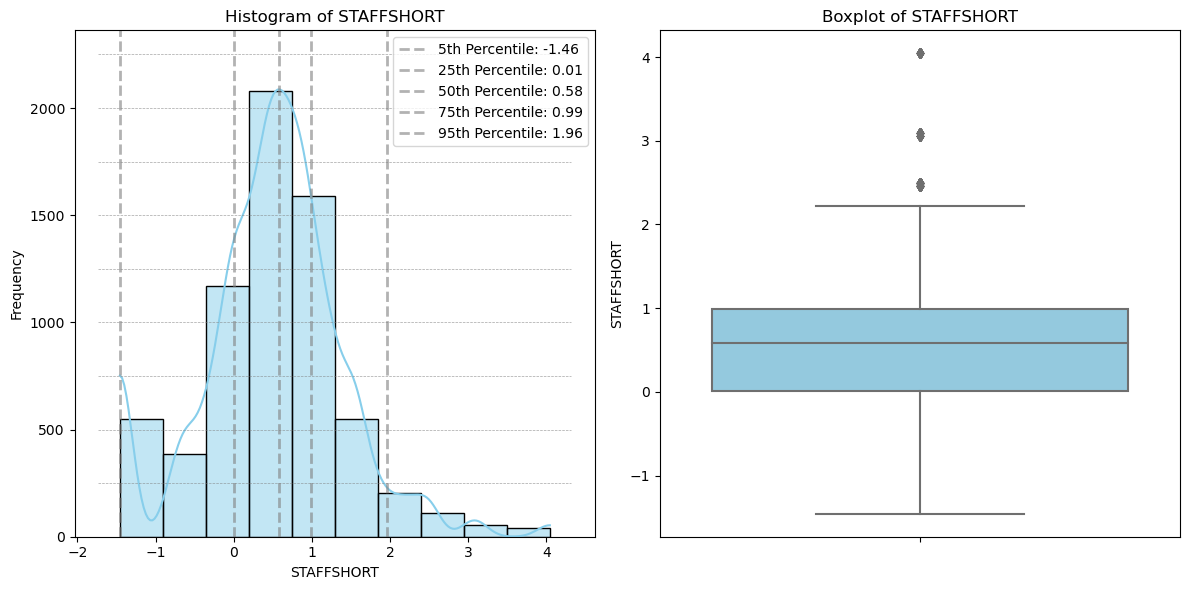

In [31]:
plot_histogram_boxplot(X_train, 'STAFFSHORT', bins = 10)

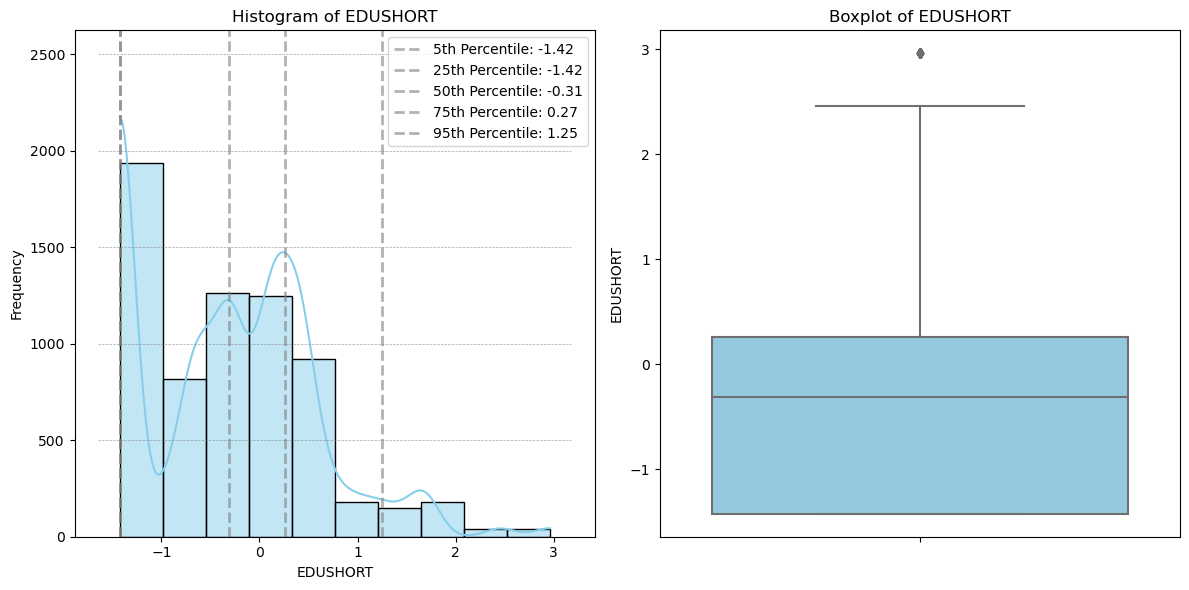

In [32]:
plot_histogram_boxplot(X_train, 'EDUSHORT', bins = 10)

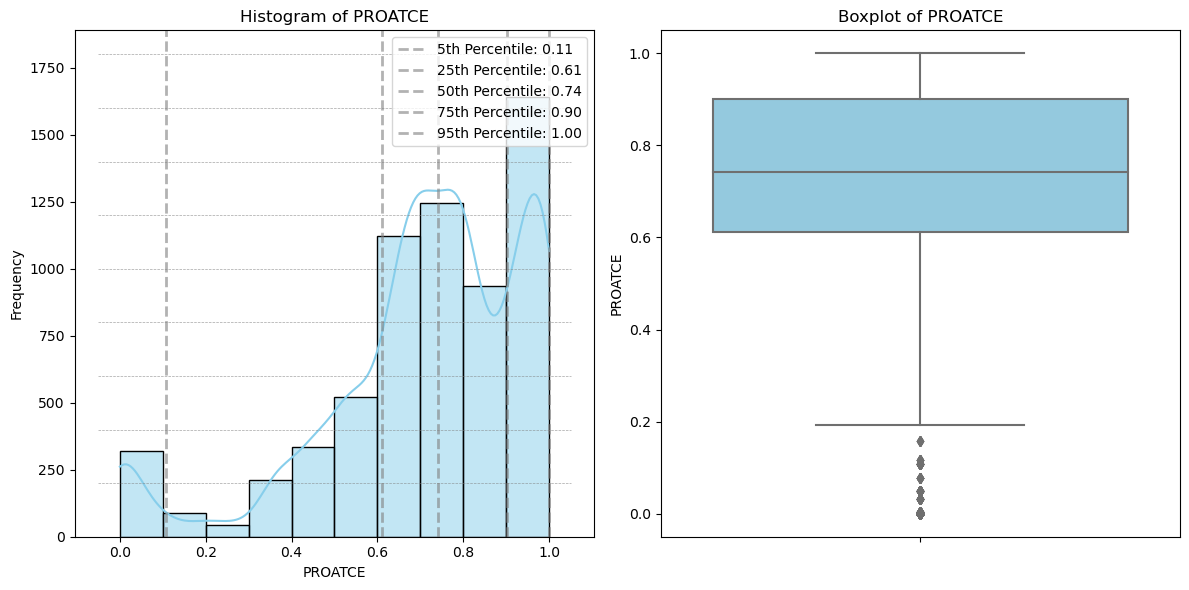

In [33]:
plot_histogram_boxplot(X_train, 'PROATCE', bins = 10)

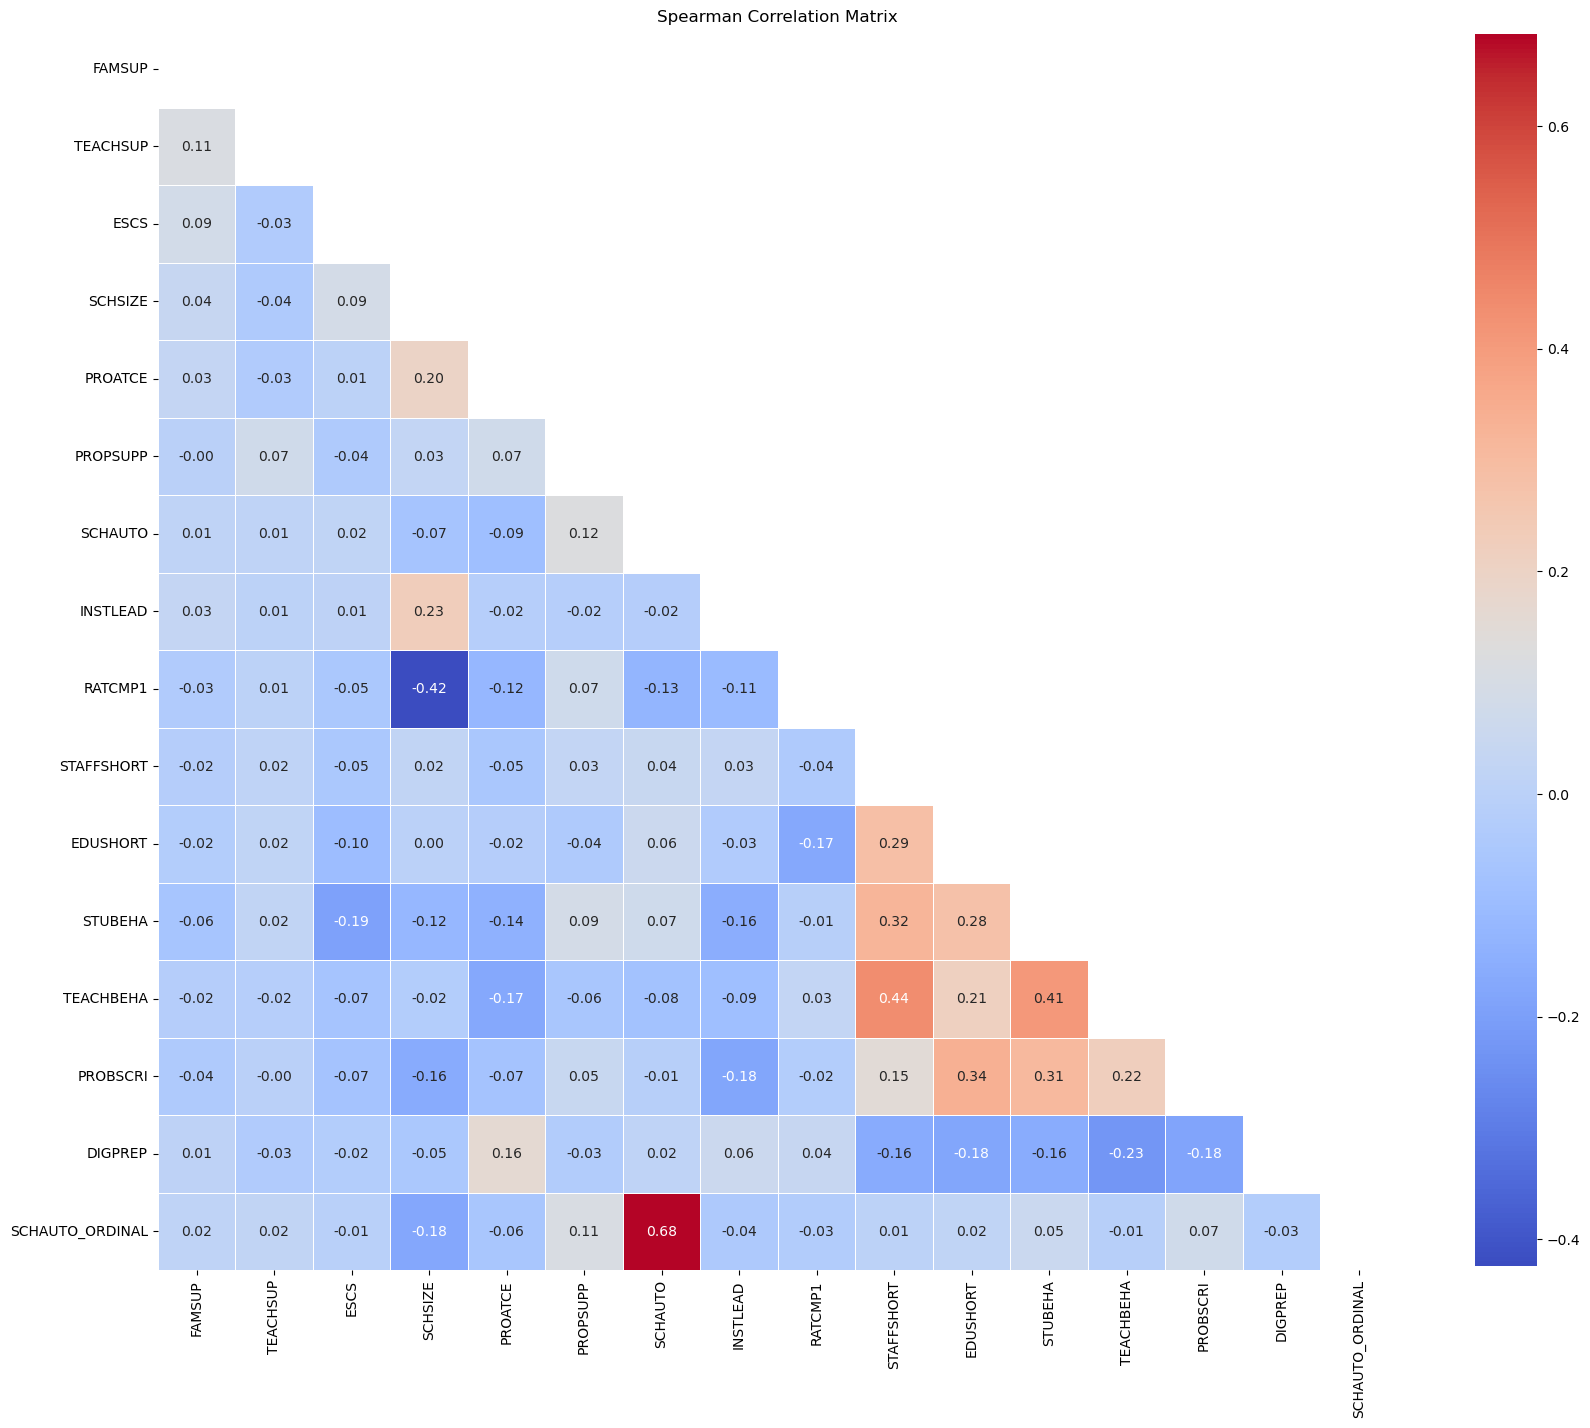

In [34]:
# plotting spearman correlation matrix:
continuos_features = X_train.select_dtypes(include=['float64', 'int64'])
df_heatmap = X_train[continuos_features.columns]
corr = df_heatmap.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Spearman Correlation Matrix')
plt.show()

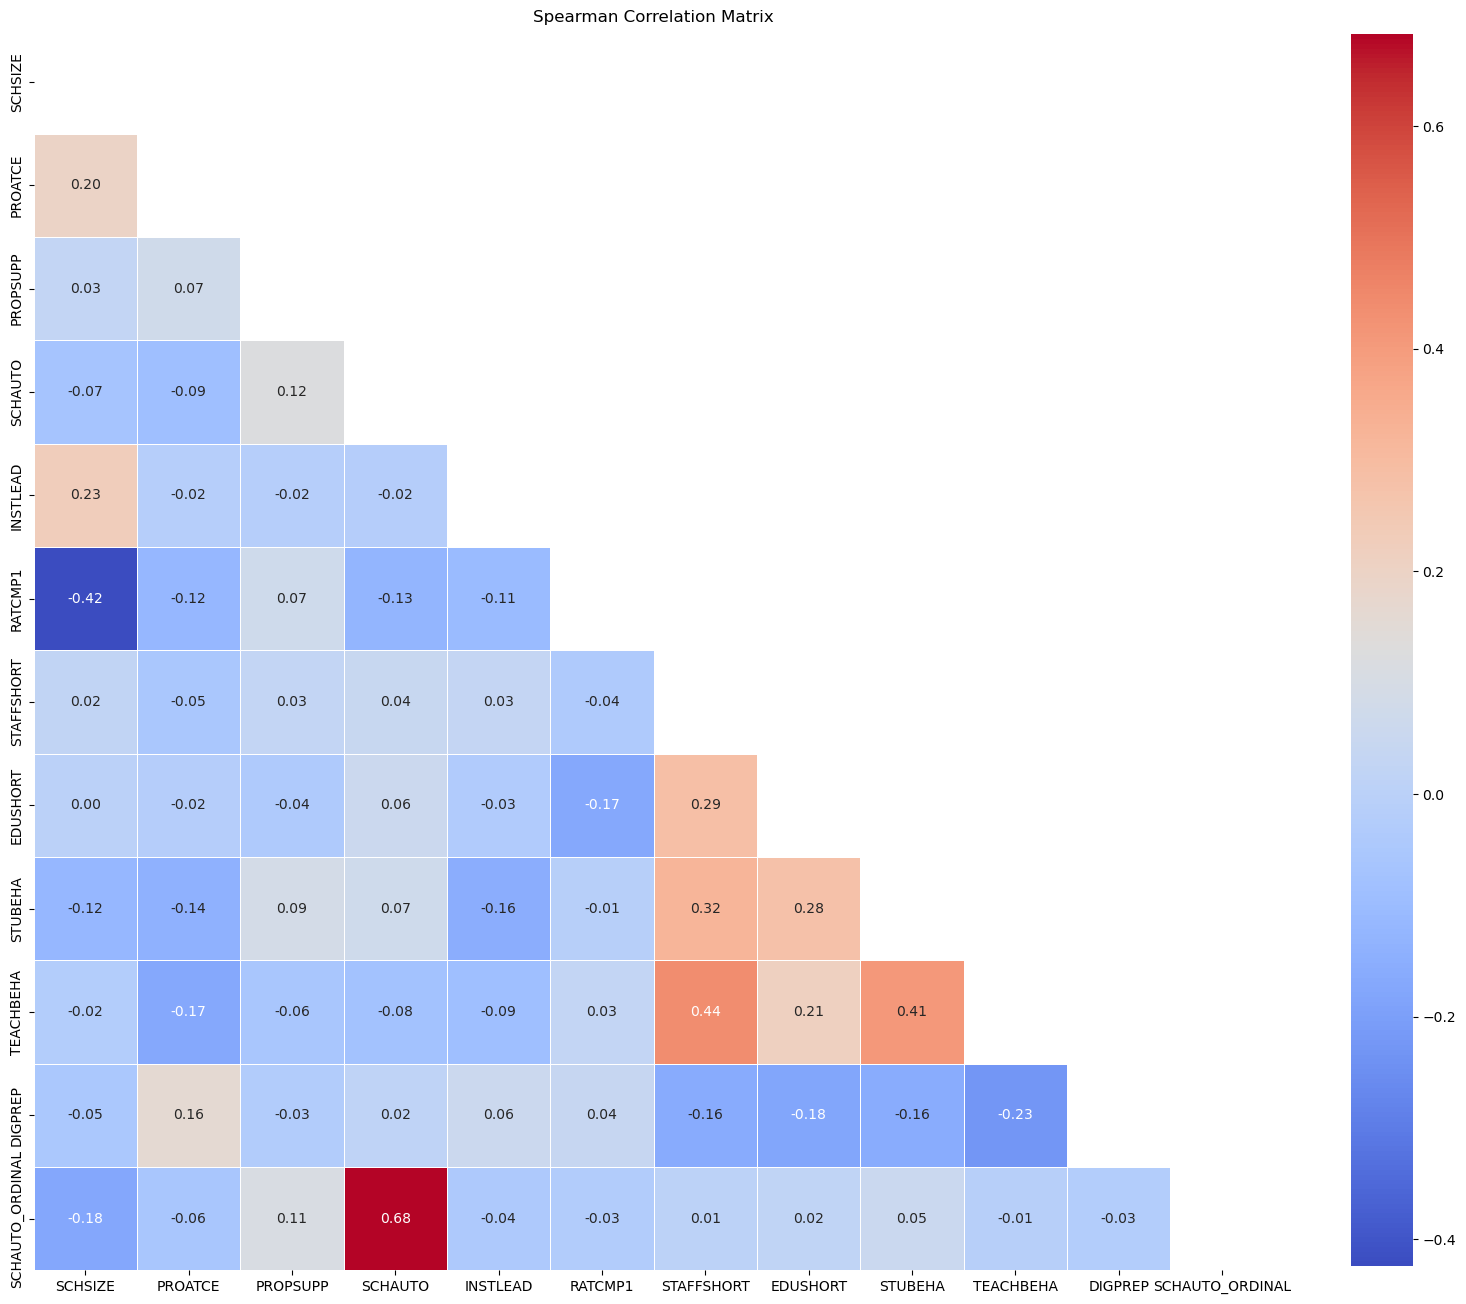

In [35]:
continuos_sch = [col for col in X_train if col in continuos_features and col in sch_cols]
continuos_st = [col for col in X_train if col in continuos_features and col in st_cols ]
df_heatmap = X_train[continuos_sch]
corr = df_heatmap.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Spearman Correlation Matrix')
plt.show()

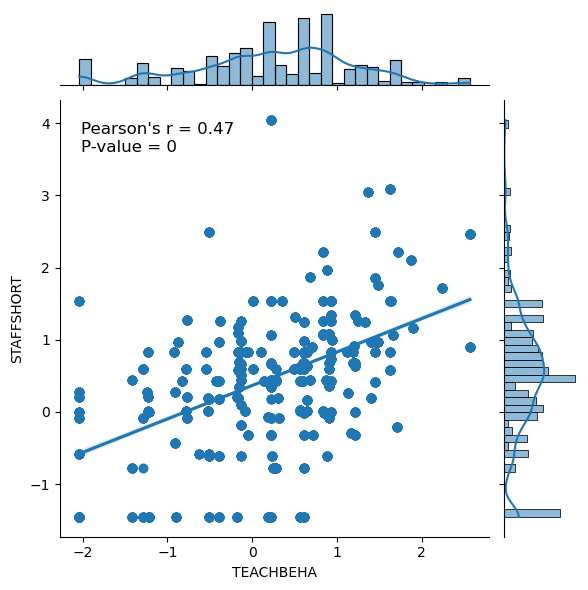

In [37]:
columns = X_train[['TEACHBEHA', 'STAFFSHORT']].dropna()
r, p_value = stats.pearsonr(columns['TEACHBEHA'], columns['STAFFSHORT'])
g = sns.jointplot(x ='TEACHBEHA', y ='STAFFSHORT', data = X_train, kind = 'reg')
g.ax_joint.text(0.05, 0.95,
                f"Pearson's r = {r:.2f}\nP-value = {p_value:.2g}",
                fontsize=12, ha='left', va='top',
                transform=g.ax_joint.transAxes)
plt.show()

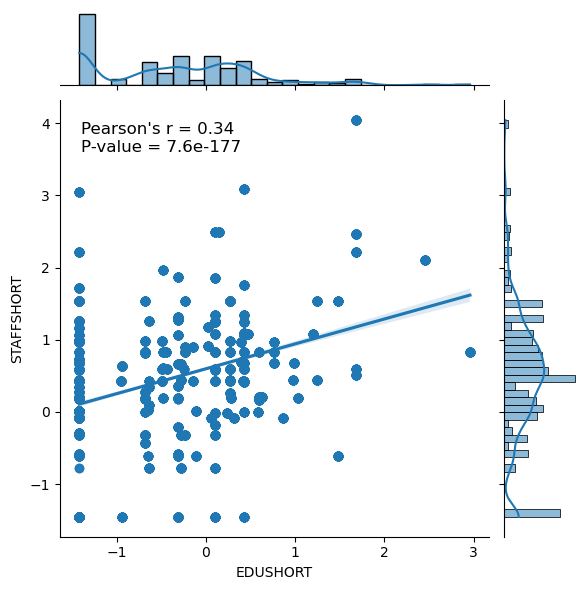

In [125]:
columns = X_train[['EDUSHORT', 'STAFFSHORT']].dropna()
r, p_value = stats.pearsonr(columns['EDUSHORT'], columns['STAFFSHORT'])
g = sns.jointplot(x ='EDUSHORT', y ='STAFFSHORT', data = X_train, kind = 'reg')
g.ax_joint.text(0.05, 0.95,
                f"Pearson's r = {r:.2f}\nP-value = {p_value:.2g}",
                fontsize=12, ha='left', va='top',
                transform=g.ax_joint.transAxes)
plt.show()

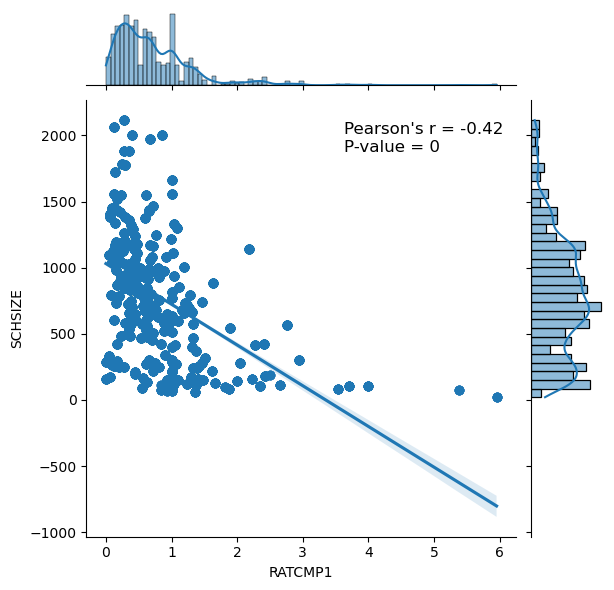

In [ ]:
columns = df[['RATCMP1', 'SCHSIZE']].dropna()
r, p_value = stats.pearsonr(columns['RATCMP1'], columns['SCHSIZE'])
g = sns.jointplot(x ='RATCMP1', y ='SCHSIZE', data = df, kind = 'reg')
g.ax_joint.text(0.60, 0.95,
                f"Pearson's r = {r:.2f}\nP-value = {p_value:.2g}",
                fontsize=12, ha='left', va='top',
                transform=g.ax_joint.transAxes)
plt.show()

In [25]:
df_clean = df[['ESCS', 'HISCED']].dropna()
# Calculate Spearman's Rank Correlation
correlation, p_value = stats.spearmanr(df_clean['ESCS'], df_clean['HISCED'])
print('correlation: ', correlation, 'p-value: ', p_value)

correlation:  0.7620242914528661 p-value:  0.0


c:\Users\mw\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


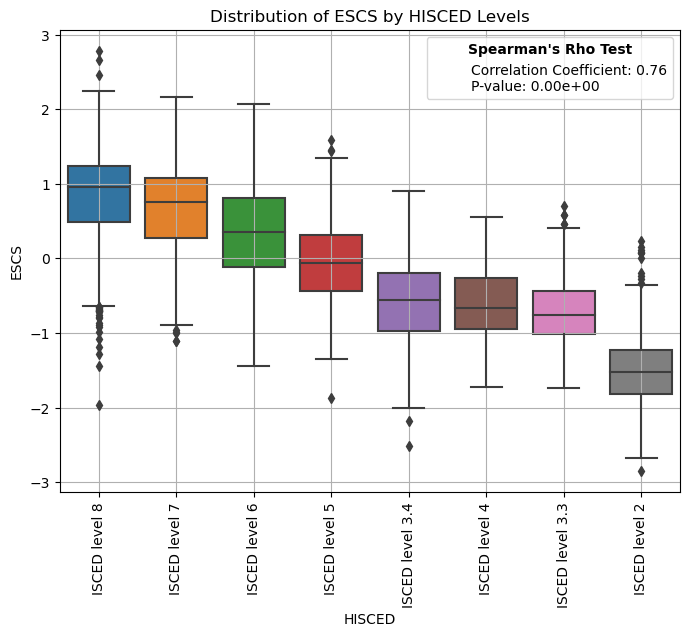

In [34]:
correlation_text = f"Correlation Coefficient: {correlation:.2f}\nP-value: {p_value:.2e}"
order = X_train.groupby('HISCED')['ESCS'].median().sort_values(ascending=False).index
df['HISCED'] = pd.Categorical(df['HISCED'], categories=order, ordered=True)
plt.figure(figsize=(8, 6))
sns.boxplot(x='HISCED', y='ESCS', data=df)
legend = plt.legend([plt.Line2D([0], [0], color="w")], [correlation_text], title="Spearman's Rho Test", loc="upper right")
legend.get_title().set_fontweight('bold')
plt.title("Distribution of ESCS by HISCED Levels")
plt.xlabel("HISCED")
plt.ylabel("ESCS")
plt.grid(True)
plt.xticks(rotation = 90)
plt.show()

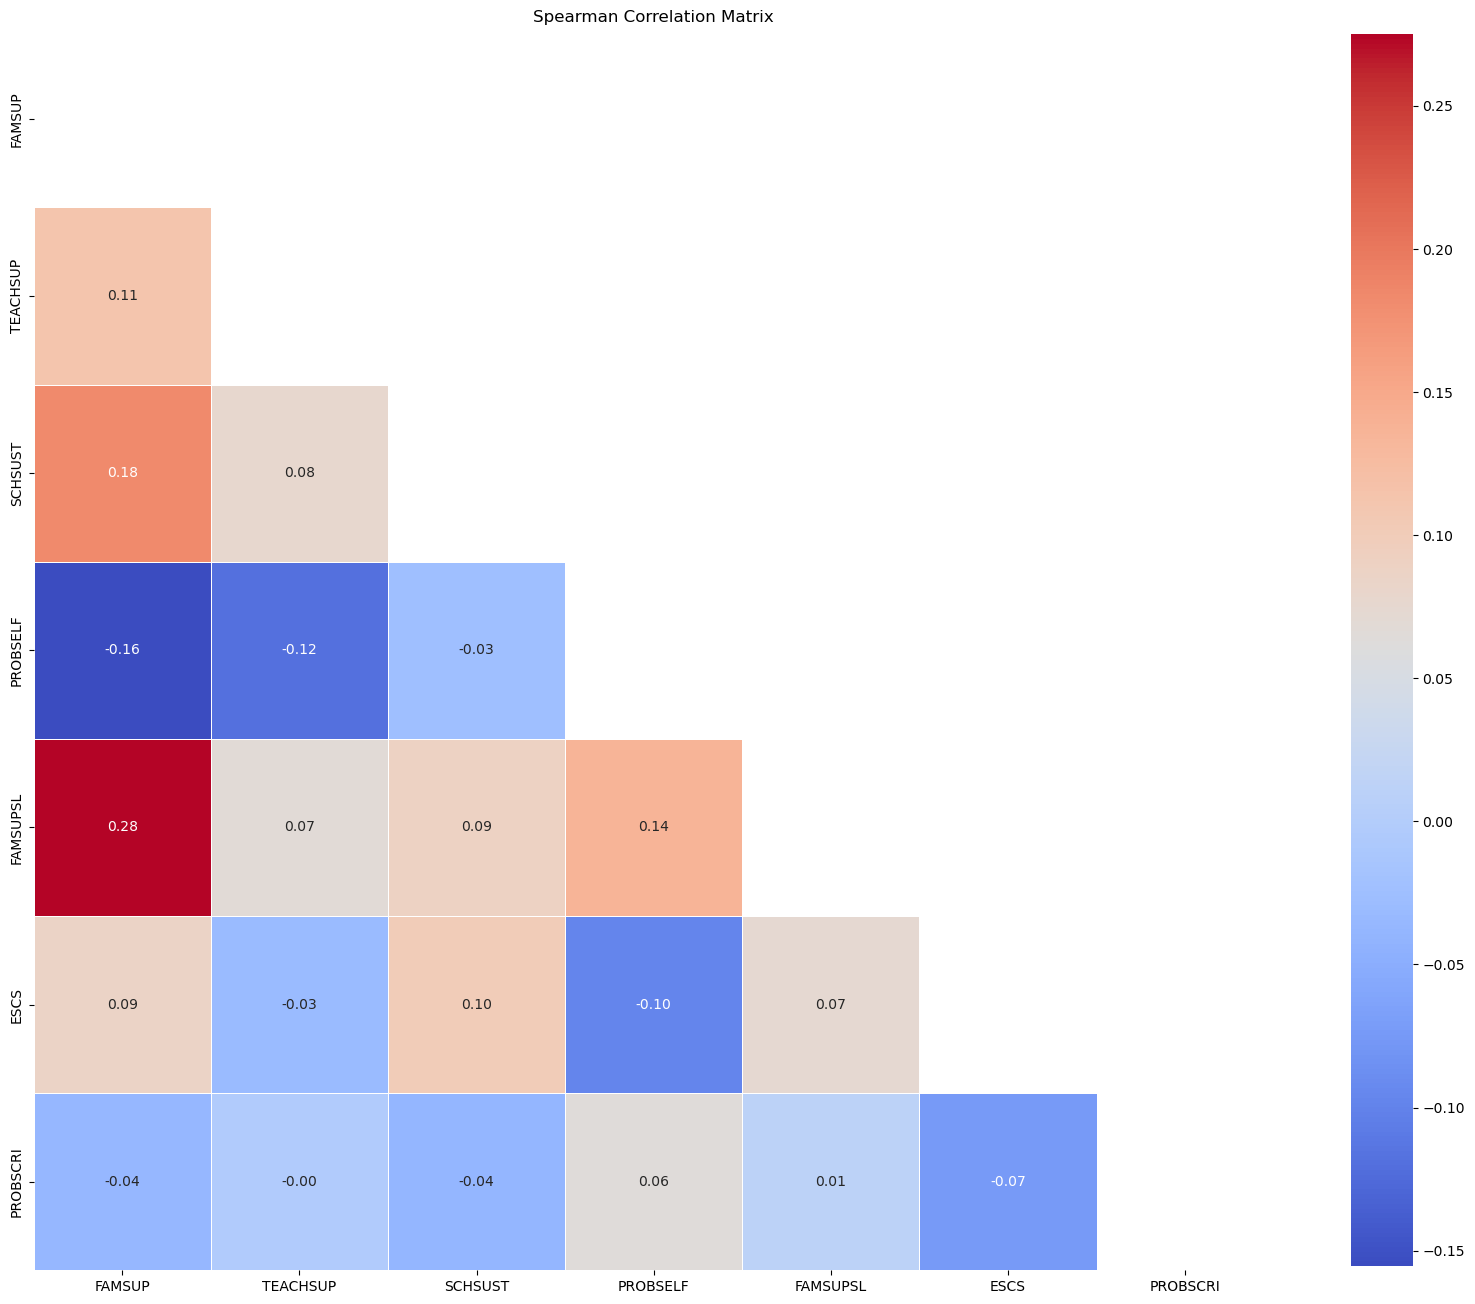

In [26]:
df_heatmap = X_train[continuos_st]
corr = df_heatmap.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Spearman Correlation Matrix')
plt.show()